# Compare emissions factors for different processes

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

colors = ['#d73027', '#fc8d59', '#91bfdb', '#4575b4']# ['#E66070', '#E6A730', '#6EE588', '#498DE6', '#A055E6']+['pink']

In [18]:
## Inputs
input_path = '/Users/lukecullen/PycharmProjects/petrochemical-data/data/' #../data/'
output_path = '/Users/lukecullen/Library/CloudStorage/OneDrive-UniversityofCambridge/PhD/C-THRU/paper_2_finalisation/figures/'#'../analysis_outputs/'
combined_factors = pd.read_csv(input_path+'combined/processConversionFactors_allgases_allalloc_dedoubled.csv')#processConversionFactors_allgases_allalloc_ammonia.csv')
reduced = combined_factors.copy()#[combined_factors.columns[['sigma' not in i for i in combined_factors.columns]]]
reduced = reduced[reduced['ihs_match']!='PET PELLETS, BOTTLE GRADE (IV 0.82 DL/G) PRODUCTION FROM PET POLYMER MELT BY POLYMETRIX ECOSPHERE SSP']

In [3]:
# Product grouping
product_grouping = pd.read_csv(input_path+'extra_inputs/product_groups.csv', index_col=0)
product_grouping = product_grouping.dropna(subset=['Product group']).reset_index(drop=True)
grouped_emissions = pd.merge(reduced, product_grouping, left_on='Product', right_on='PRODUCT', how='left')

name_matching_ints = {'PROPYLENE, CHEM GRADE':'PROPYLENE', 'PROPYLENE, REFINERY GRADE':'PROPYLENE', 'PROPYLENE, POLYMER GRADE':'PROPYLENE',
 'P-XYLENE':'PARA-XYLENE', 'O-XYLENE':'ORTHO-XYLENE', 'XYLENES, MIXED':'MIXED XYLENES','METHANOL, CRUDE':'METHANOL'}
grouped_emissions['Product'] = grouped_emissions['Product'].replace(name_matching_ints)

fert_names = {'AMMONIA':'AMMONIA', 'AMMONIUM NITRATE FERTILIZER':'AMMONIUM NITRATE', 'HYDROXYLAMMONIUM SULFATE':'AMMONIUM SULPHATE', 'UREA, AGRICULTURAL GRADE':'UREA'}

plastic_names = {'ABS RESIN':'ABS',
                'POLYSTYRENE, EXP': 'EXPANDABLE PS',
                'POLYETHYLENE, HD': 'HDPE', 'POLYETHYLENE, HD POWDERED':'HDPE', 'POLYETHYLENE, HDPE BM':'HDPE',
                'POLYETHYLENE, LD':'LDPE',
                'POLYETHYLENE, LLD':'LLDPE', 'POLYETHYLENE, LLD BM':'LLDPE',
                'PET PELLETS (30% GF)':'PET', 'PET PELLETS (IV=0.6)':'PET', 'PET PELLETS (IV=0.7)':'PET', 'PET PELLETS (IV=0.8)':'PET',  'PET PELLETS (IV=0.82)':'PET', 'PET PELLETS (IV=1.04), SP GRADE':'PET', 'PET PELLETS, GLYCOL MODIFIED':'PET', 'PET POLYMER MELT':'PET',
                'POLYESTER, UNSATURATED':'POLYESTER POLYMER',
                'POLYPROPYLENE':'POLYPROPYLENE',
                'POLYSTYRENE, GP': 'POLYSTYRENE', 'POLYSTYRENE, HI':'POLYSTYRENE',
                'POLYVINYL CHLORIDE':'PVC'
                }

grouped_emissions['Product'] = grouped_emissions['Product'].replace(fert_names)
grouped_emissions['Product'] = grouped_emissions['Product'].replace(plastic_names)
grouped_emissions['Product'] = grouped_emissions['Product'].str.replace(' ', '\n')

In [4]:
def contains_substring(string, substrings):
    for substring in substrings:
        if substring in string:
            return True
    return False


def get_allocation_totals(df:pd.DataFrame, gas:str, allocation:str):
    efs = df[['Product','ihs_match']+list([col for col in df.columns if gas in col and contains_substring(col, stages_used) and allocation in col and 'sigma' not in col])]
    efs['Total'] = efs[efs.columns[2:]].sum(axis=1)
    return efs.dropna(subset=list(efs.columns[2:-1]), how='all')

def filter_df(df, cols, filters):
    for col, filt in zip(cols, filters):
        df = df[[i in filt for i in df[col]]]
    return df

# Figure 1 - Difference in processes for individual product

In [5]:
primary_chems = ['AMMONIA', 'BUTADIENE', 'BENZENE', 'ETHYLENE', 'METHANOL', 'PROPYLENE', 'TOLUENE', 'MIXED\nXYLENES', 'PARA-XYLENE']
plastics = ['ABS', 'HDPE', 'LDPE', 'LLDPE', 'PET', 'POLYESTER\nPOLYMER', 'POLYPROPYLENE', 'POLYSTYRENE', 'PVC']#'EXPANDABLE PS',
stages_used = ['Direct Process', 'Feedstock', 'Direct Utilities', 'Indirect Utilities', 'Primary chemicals', 'Organic chemicals', 'Other intermediates']
gas = 'CO2e_100a'

In [6]:
mass_efs = get_allocation_totals(grouped_emissions, gas, 'mass')

ei_vals = grouped_emissions[['Product', 'ei_CO2e_100a_conv_factor']]
cm_vals = grouped_emissions[['Product', 'cm_CO2e_100a_conv_factor']]
ifa_vals = grouped_emissions[['Product', 'ifa_CO2e_100a_CtOG factor']]


## mismatch_corrections
ei_vals.loc[ei_vals[ei_vals['Product']=='PVC'].index, 'ei_CO2e_100a_conv_factor'] = 2.49
ei_vals.loc[ei_vals[ei_vals['Product']=='ABS'].index, 'ei_CO2e_100a_conv_factor'] = 4.48

cm_vals = pd.concat((cm_vals, pd.DataFrame(np.array([['POLYSTYRENE','HDPE', 'LDPE', 'LLDPE'], [2.22, 2.06, 2.49, 2.21]]).transpose(), columns=list(cm_vals.columns))))
cm_vals['cm_CO2e_100a_conv_factor'] = cm_vals['cm_CO2e_100a_conv_factor'].astype(float)

/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_16154/3735777062.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  efs['Total'] = efs[efs.columns[2:]].sum(axis=1)


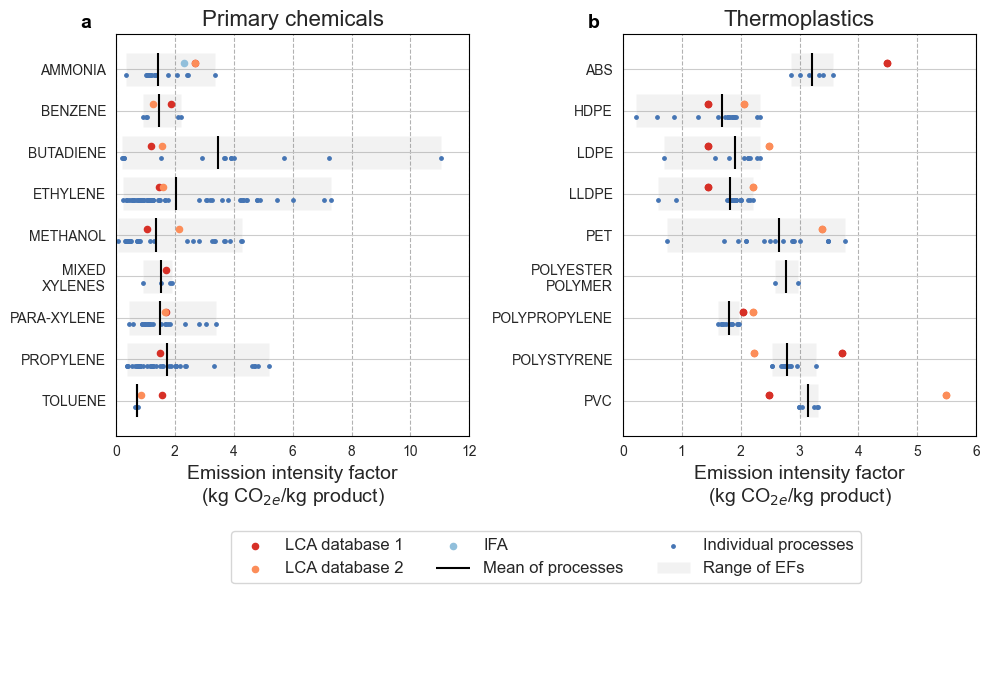

In [7]:
fig = plt.figure(figsize=[10, 7])

axs = [fig.add_subplot(3,2,(1,3)), fig.add_subplot(3,2,(2,4))]

[ax.set_facecolor('white') for ax in axs]
for ax in axs:
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')

for i, (df, color, label) in enumerate(zip([ei_vals, cm_vals, ifa_vals], colors, ['LCA database 1', 'LCA database 2', 'IFA'])):
    df = filter_df(df, ['Product'], [primary_chems]).sort_values('Product', ascending=False).groupby('Product').mean().reset_index()
    if i==0:
        height_dict = dict(zip(df['Product'].unique(), range(len(df['Product'].unique()))))
        
ihs_mins = filter_df(mass_efs, ['Product'], [primary_chems]).sort_values('Product', ascending=False).groupby('Product').min()['Total']
ihs_maxs = filter_df(mass_efs, ['Product'], [primary_chems]).sort_values('Product', ascending=False).groupby('Product').max()['Total']
axs[0].barh(pd.Series(ihs_mins.index).replace(height_dict), ihs_maxs-ihs_mins, left=ihs_mins, color='grey', alpha=0.1, label='Range of EFs')

for i, (df, color, label) in enumerate(zip([ei_vals, cm_vals, ifa_vals], colors, ['LCA database 1', 'LCA database 2', 'IFA'])):
    df = filter_df(df, ['Product'], [primary_chems]).sort_values('Product', ascending=False).groupby('Product').mean().reset_index()
    # if i==0:
    #     height_dict = dict(zip(df['Product'].unique(), range(len(df['Product'].unique()))))
    axs[0].scatter(df[list(df.columns)[-1]], df['Product'].replace(height_dict)-0.15, color=color, s=20, label=label)

mass_plots = filter_df(mass_efs, ['Product'], [primary_chems]).sort_values('Product', ascending=False).drop(columns='ihs_match').groupby('Product').mean().reset_index()

    #filter_df(mass_efs, ['Product'], [primary_chems]).sort_values('Product', ascending=False).groupby('Product').mean().reset_index()
#axs[0].scatter(mass_plots['Total'], mass_plots['Product'].replace(height_dict)-0.2, color=colors[3], s=20, label='Mean of processes\nin this study')
#axs[0].plot(mass_plots['Total'], mass_plots['Product'].replace(height_dict)-0.2, color=colors[3], s=20, label='Mean of processes\nin this study')
bar_width = 0.8  # Adjust this value to control the width of the bars
axs[0].vlines(mass_plots['Total'], ymin=mass_plots['Product'].replace(height_dict)-0.4, ymax=mass_plots['Product'].replace(height_dict)-0.4+bar_width, color='black', label = 'Mean of processes')
#for i, (df, color, label) in enumerate(zip([mass_efs, energy_efs, economic_efs], colors[3:], ['Mass', 'Energy', 'Cost'])):
plot_chems = filter_df(mass_efs, ['Product'], [primary_chems]).sort_values('Product', ascending=False)
axs[0].scatter(plot_chems['Total'], plot_chems['Product'].replace(height_dict)+0.15, color=colors[3], s=6, label='Individual processes')

# eth_avg = mass_plots.copy()

fontsize = 14
axs[0].set_title('Primary chemicals', fontsize=fontsize+2)
axs[0].set_yticks(range(len(height_dict)))
axs[0].set_yticklabels(list(height_dict.keys()))
axs[0].invert_yaxis()
axs[0].set_xlim([0, 12])
axs[0].set_xlabel('Emission intensity factor\n(kg CO$_{2e}$/kg product)', fontsize=fontsize)
axs[0].grid(axis='x', linestyle='--', color='k', alpha=0.3)

## Plastics

for i, (df, color, label) in enumerate(zip([ei_vals, cm_vals, ifa_vals], colors, ['LCA database 1', 'LCA database 2', 'IFA'])):
    df = filter_df(df, ['Product'], [plastics]).sort_values('Product', ascending=False).groupby('Product').mean().reset_index()
    if i==0:
        height_dict = dict(zip(df['Product'].unique(), range(len(df['Product'].unique()))))
    axs[1].scatter(df[list(df.columns)[-1]], df['Product'].replace(height_dict)-0.15, color=color, s=20, label=label)


ihs_mins = filter_df(mass_efs, ['Product'], [plastics]).sort_values('Product', ascending=False).groupby('Product').min()['Total']
ihs_maxs = filter_df(mass_efs, ['Product'], [plastics]).sort_values('Product', ascending=False).groupby('Product').max()['Total']
axs[1].barh(pd.Series(ihs_mins.index).replace(height_dict), ihs_maxs-ihs_mins, left=ihs_mins, color='grey', alpha=0.1, label='Range')

for i, (df, color, label) in enumerate(zip([ei_vals, cm_vals, ifa_vals], colors, ['LCA database 1', 'LCA database 2', 'IFA'])):
    df = filter_df(df, ['Product'], [plastics]).sort_values('Product', ascending=False).groupby('Product').mean().reset_index()
    # if i==0:
    #     height_dict = dict(zip(df['Product'].unique(), range(len(df['Product'].unique()))))
    axs[1].scatter(df[list(df.columns)[-1]], df['Product'].replace(height_dict)-0.15, color=color, s=20, label=label)

mass_plots = filter_df(mass_efs, ['Product'], [plastics]).sort_values('Product', ascending=False).drop(columns='ihs_match').groupby('Product').mean().reset_index()
#axs[1].scatter(mass_plots['Total'], mass_plots['Product'].replace(height_dict)-0.2, color=colors[3], s=20, label='Mean of processes\nin this study')
#axs[1].plot(mass_plots['Total'], mass_plots['Product'].replace(height_dict)-0.2, color=colors[3], s=20, label='Mean of processes\nin this study')

bar_width = 0.8  # Adjust this value to control the width of the bars
axs[1].vlines(mass_plots['Total'], ymin=mass_plots['Product'].replace(height_dict)-0.4, ymax=mass_plots['Product'].replace(height_dict)-0.4+bar_width, color='black', label = 'Mean of processes')
#for i, (df, color, label) in enumerate(zip([mass_efs, energy_efs, economic_efs], colors[3:], ['Mass', 'Energy', 'Cost'])):
plot_chems = filter_df(mass_efs, ['Product'], [plastics]).sort_values('Product', ascending=False)
axs[1].scatter(plot_chems['Total'], plot_chems['Product'].replace(height_dict)+0.15, color=colors[3], s=6, label='Individual processes')

fontsize = 14
axs[1].set_title('Thermoplastics', fontsize=fontsize+2)
axs[1].set_yticks(range(len(height_dict)))
axs[1].set_yticklabels(list(height_dict.keys()))
axs[1].invert_yaxis()
axs[1].set_xlim([0, 6])
axs[1].set_xlabel('Emission intensity factor\n(kg CO$_{2e}$/kg product)', fontsize=fontsize)
axs[1].grid(axis='x', linestyle='--', color='k', alpha=0.3)


# Create the legend outside of the subplots
ax_legend = fig.add_subplot(3,2,(5,6))
lines, labels = fig.axes[0].get_legend_handles_labels()
ax_legend.legend(lines, labels, loc='upper center', ncol=3, fontsize=fontsize-2)#, bbox_to_anchor=(1.0, 0.5))
ax_legend.axis('off')
ax_legend.set_facecolor('white')
#fig.suptitle('Range of emission intensity factors for products', fontsize=fontsize+4)

w, h = -0.1, 1.05
axs[0].text(w, h, 'a', transform = axs[0].transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
axs[1].text(w, h, 'b', transform = axs[1].transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})

fig.tight_layout()

In [23]:
plot_chems[['Product', 'Total']].reset_index().sort_values(['Product', 'Total']).rename(columns={'Total':'Emission intensity factor', 'index':'IHS ref'}).to_csv('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs\data_tables/fig2_primaryChemicals.csv')

OSError: Cannot save file into a non-existent directory: 'C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs\data_tables'

In [116]:
# Save output plot
fig.savefig(output_path+'Figure_3.eps', format='eps', bbox_inches='tight',dpi=300)

# Save output plot
fig.savefig(output_path+'Figure_3.png', format='png', bbox_inches='tight',dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## Figure SI 1

In [45]:
pgs = pd.read_csv('/Users/lukecullen/PycharmProjects/petrochemical-data/data/extra_inputs/product_groups.csv')
pgs['PRODUCT'] = pgs['PRODUCT'].str.replace(' ', '\n')
grouped_emissions = grouped_emissions.merge(pgs, left_on=['Product'], right_on='PRODUCT')

In [46]:
organic_chems = filter_df(grouped_emissions, ['Product group_x'], [['Organic chemicals']])['Product'].unique()
thermosets = filter_df(grouped_emissions, ['Product group_x'], [['Thermosets, fibre & elastomers']])['Product'].unique()
solvents = filter_df(grouped_emissions, ['Product group_x'], [['Solvents, additives & explosives']])['Product'].unique()
other_ds = filter_df(grouped_emissions, ['Product group_x'], [['Other downstream']])['Product'].unique()
other_ints = filter_df(grouped_emissions, ['Product group_x'], [['Other intermediates']])['Product'].unique()
all_ds = list(thermosets)+list(solvents)+fertilisers+list(other_ds)

In [47]:
mass_efs = get_allocation_totals(grouped_emissions, gas, 'mass')

ei_vals = grouped_emissions[['Product', 'ei_CO2e_100a_conv_factor']]
cm_vals = grouped_emissions[['Product', 'cm_CO2e_100a_conv_factor']]
ifa_vals = grouped_emissions[['Product', 'ifa_CO2e_100a_CtOG factor']]

## mismatch_corrections
ei_vals.loc[ei_vals[ei_vals['Product']=='PVC'].index, 'ei_CO2e_100a_conv_factor'] = 2.49
ei_vals.loc[ei_vals[ei_vals['Product']=='ABS'].index, 'ei_CO2e_100a_conv_factor'] = 4.48

cm_vals = pd.concat((cm_vals, pd.DataFrame(np.array([['POLYSTYRENE','HDPE', 'LDPE', 'LLDPE'], [2.22, 2.06, 2.49, 2.21]]).transpose(), columns=list(cm_vals.columns))))
cm_vals['cm_CO2e_100a_conv_factor'] = cm_vals['cm_CO2e_100a_conv_factor'].astype(float)

/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_16154/3735777062.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  efs['Total'] = efs[efs.columns[2:]].sum(axis=1)


In [49]:
filter_df(mass_efs, ['Product'], [organic_chems]).sort_values('Product', ascending=False).drop(columns=['ihs_match'])

,Product,ihs_match,"Direct Utilities CO2e_100a, mass allocation factor","Indirect Utilities CO2e_100a, mass allocation factor","Feedstock CO2e_100a, mass allocation factor","Primary chemicals CO2e_100a, mass allocation factor","Organic chemicals CO2e_100a, mass allocation factor","Direct Process CO2e_100a, mass allocation factor","Other intermediates CO2e_100a, mass allocation factor",Total
522,STYRENE,STYRENE FROM BENZENE AND ETHYLENE VIA LIQUID-P...,1.887567e-01,0.234774,0.000049,1.570256,NaN,0.0,NaN,1.993836
516,STYRENE,STYRENE VIA BENZENE AND ETHANE,8.965797e-02,1.417384,0.254709,1.010893,NaN,0.0,NaN,2.772644
510,STYRENE,STYRENE FROM BENZENE AND ETHYLENE VIA LIQUID-P...,4.021193e-01,0.481338,0.000000,1.534659,NaN,0.0,NaN,2.418116
511,STYRENE,STYRENE BY CB&I/UOP CLASSIC STYRENE TECHNOLOGY,1.751259e-08,0.647232,0.000000,NaN,1.403957,0.0,NaN,2.051189
513,STYRENE,STYRENE BY CB&I/UOP SMART PROCESS LOW CAPACITY,1.421432e-02,0.706216,0.000000,NaN,1.414629,0.0,NaN,2.135059
...,...,...,...,...,...,...,...,...,...,...
1,"1,4-BUTANEDIOL","1,4-BUTANEDIOL FROM GLUCOSE (DIRECT ROUTE)",0.000000e+00,5.033697,3.356051,0.066086,NaN,NaN,NaN,8.455834
5,"1,4-BUTANEDIOL","1,4-BUTANEDIOL FROM ACETYLENE AND FORMALDEHYDE",0.000000e+00,3.307546,2.640503,NaN,NaN,NaN,NaN,5.948049
6,"1,4-BUTANEDIOL","1,4-BUTANEDIOL FROM BUTADIENE",0.000000e+00,3.310462,0.063834,0.851946,0.059273,NaN,NaN,4.285515
7,"1,4-BUTANEDIOL","1,4-BUTANEDIOL FROM ACETYLENE AND FORMALDEHYDE...",0.000000e+00,3.245077,2.599637,NaN,NaN,NaN,NaN,5.844713


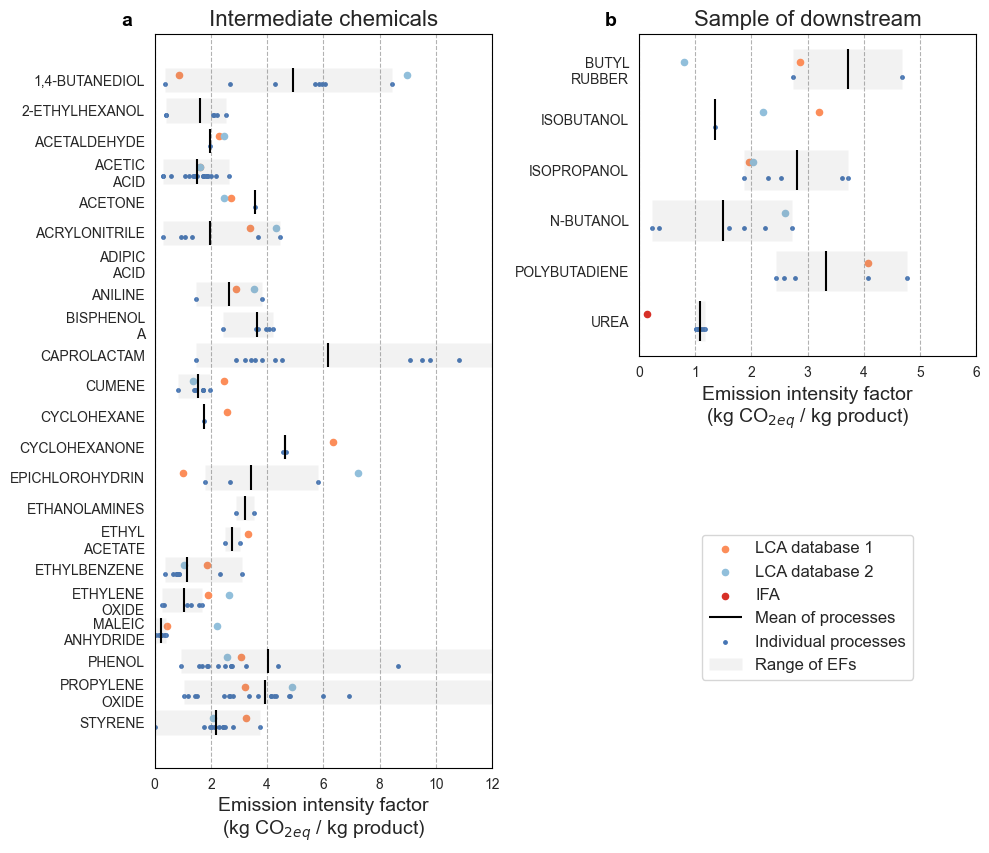

In [52]:
fig = plt.figure(figsize=[10, 12], facecolor='white')

axs = [fig.add_subplot(3,2,(1,3)), fig.add_subplot(3,2,(2)), fig.add_subplot(3,2,(4))]

[ax.set_facecolor('white') for ax in axs]
for ax in axs:
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')

for i, (df, color, label) in enumerate(zip([ei_vals, cm_vals, ifa_vals], colors[1:3]+[colors[0]], ['LCA database 1', 'LCA database 2', 'IFA'])):
    df = filter_df(df, ['Product'], [organic_chems]).sort_values('Product', ascending=False).groupby('Product').mean().reset_index()
    if i==0:
        height_dict = dict(zip(df['Product'].unique(), range(len(df['Product'].unique()))))
    axs[0].scatter(df[list(df.columns)[-1]], df['Product'].replace(height_dict)-0.15, color=color, s=20, label=label)

mass_plots = filter_df(mass_efs, ['Product'], [organic_chems]).sort_values('Product', ascending=False).drop(columns=['ihs_match']).groupby('Product').mean().reset_index()
#axs[0].scatter(mass_plots['Total'], mass_plots['Product'].replace(height_dict)-0.2, color=colors[3], s=20, label='Mean of processes\nin this study')
#axs[0].plot(mass_plots['Total'], mass_plots['Product'].replace(height_dict)-0.2, color=colors[3], s=20, label='Mean of processes\nin this study')
bar_width = 0.8  # Adjust this value to control the width of the bars
axs[0].vlines(mass_plots['Total'], ymin=mass_plots['Product'].replace(height_dict)-0.4, ymax=mass_plots['Product'].replace(height_dict)-0.4+bar_width, color='black', label = 'Mean of processes')
#for i, (df, color, label) in enumerate(zip([mass_efs, energy_efs, economic_efs], colors[3:], ['Mass', 'Energy', 'Cost'])):
plot_chems = filter_df(mass_efs, ['Product'], [organic_chems]).sort_values('Product', ascending=False)
axs[0].scatter(plot_chems['Total'], plot_chems['Product'].replace(height_dict)+0.15, color=colors[3], s=6, label='Individual processes')

ihs_mins = filter_df(mass_efs, ['Product'], [organic_chems]).sort_values('Product', ascending=False).groupby('Product').min()['Total']
ihs_maxs = filter_df(mass_efs, ['Product'], [organic_chems]).sort_values('Product', ascending=False).groupby('Product').max()['Total']
axs[0].barh(pd.Series(ihs_mins.index).replace(height_dict), ihs_maxs-ihs_mins, left=ihs_mins, color='grey', alpha=0.1, label='Range of EFs')

# eth_avg = mass_plots.copy()

fontsize = 14
axs[0].set_title('Intermediate chemicals', fontsize=fontsize+2)
axs[0].set_yticks(range(len(height_dict)))
axs[0].set_yticklabels(list(height_dict.keys()))
axs[0].invert_yaxis()
axs[0].set_xlim([0, 12])
axs[0].set_xlabel('Emission intensity factor\n(kg CO$_{2eq}$ / kg product)', fontsize=fontsize)
axs[0].grid(False)
axs[0].grid(axis='x', linestyle='--', color='k', alpha=0.3)

## Plastics
for i, (df, color, label) in enumerate(zip([ei_vals, cm_vals, ifa_vals], colors[1:3]+[colors[0]], ['LCA database 1', 'LCA database 2', 'IFA'])):
    df = filter_df(df, ['Product'], [all_ds]).sort_values('Product', ascending=False).groupby('Product').mean().reset_index()
    if i==0:
        height_dict = dict(zip(df['Product'].unique(), range(len(df['Product'].unique()))))
    axs[1].scatter(df[list(df.columns)[-1]], df['Product'].replace(height_dict)-0.15, color=color, s=20, label=label)

mass_plots = filter_df(mass_efs, ['Product'], [all_ds]).sort_values('Product', ascending=False).drop(columns=['ihs_match']).groupby('Product').mean().reset_index()
#axs[1].scatter(mass_plots['Total'], mass_plots['Product'].replace(height_dict)-0.2, color=colors[3], s=20, label='Mean of processes\nin this study')
#axs[1].plot(mass_plots['Total'], mass_plots['Product'].replace(height_dict)-0.2, color=colors[3], s=20, label='Mean of processes\nin this study')
bar_width = 0.8  # Adjust this value to control the width of the bars
axs[1].vlines(mass_plots['Total'], ymin=mass_plots['Product'].replace(height_dict)-0.4, ymax=mass_plots['Product'].replace(height_dict)-0.4+bar_width, color='black', label = 'Mean of processes')
#for i, (df, color, label) in enumerate(zip([mass_efs, energy_efs, economic_efs], colors[3:], ['Mass', 'Energy', 'Cost'])):
plot_chems = filter_df(mass_efs, ['Product'], [all_ds]).sort_values('Product', ascending=False)
axs[1].scatter(plot_chems['Total'], plot_chems['Product'].replace(height_dict)+0.15, color=colors[3], s=6, label='Individual processes')

ihs_mins = filter_df(mass_efs, ['Product'], [all_ds]).sort_values('Product', ascending=False).groupby('Product').min()['Total']
ihs_maxs = filter_df(mass_efs, ['Product'], [all_ds]).sort_values('Product', ascending=False).groupby('Product').max()['Total']
axs[1].barh(pd.Series(ihs_mins.index).replace(height_dict), ihs_maxs-ihs_mins, left=ihs_mins, color='grey', alpha=0.1, label='Range')

fontsize = 14
axs[1].set_title('Sample of downstream', fontsize=fontsize+2)
axs[1].set_yticks(range(len(height_dict)))
axs[1].set_yticklabels(list(height_dict.keys()))
axs[1].invert_yaxis()
#axs[1].grid(axis='x', linestyle='--')
axs[1].set_xlim([0, 6])
axs[1].set_xlabel('Emission intensity factor\n(kg CO$_{2eq}$ / kg product)', fontsize=fontsize)
axs[1].grid(False)
axs[1].grid(axis='x', linestyle='--', color='k', alpha=0.3)


## Plastics
for i, (df, color, label) in enumerate(zip([ei_vals, cm_vals, ifa_vals], colors[1:3]+[colors[0]], ['LCA database 1', 'LCA database 2', 'IFA'])):
    df = filter_df(df, ['Product'], [other_ints]).sort_values('Product', ascending=False).groupby('Product').mean().reset_index()
    if i==0:
        height_dict = dict(zip(df['Product'].unique(), range(len(df['Product'].unique()))))
    axs[1].scatter(df[list(df.columns)[-1]], df['Product'].replace(height_dict)-0.15, color=color, s=20, label=label)

mass_plots = filter_df(mass_efs, ['Product'], [other_ints]).sort_values('Product', ascending=False).drop(columns=['ihs_match']).groupby('Product').mean().reset_index()
#axs[1].scatter(mass_plots['Total'], mass_plots['Product'].replace(height_dict)-0.2, color=colors[3], s=20, label='Mean of processes\nin this study')
#axs[1].plot(mass_plots['Total'], mass_plots['Product'].replace(height_dict)-0.2, color=colors[3], s=20, label='Mean of processes\nin this study')
# bar_width = 0.8  # Adjust this value to control the width of the bars
# axs[2].vlines(mass_plots['Total'], ymin=mass_plots['Product'].replace(height_dict)-0.4, ymax=mass_plots['Product'].replace(height_dict)-0.4+bar_width, color='black', label = 'Mean of processes')
# #for i, (df, color, label) in enumerate(zip([mass_efs, energy_efs, economic_efs], colors[3:], ['Mass', 'Energy', 'Cost'])):
# plot_chems = filter_df(mass_efs, ['Product'], [other_ints]).sort_values('Product', ascending=False)
# axs[2].scatter(plot_chems['Total'], plot_chems['Product'].replace(height_dict)+0.15, color=colors[3], s=6, label='Individual processes')
#
# ihs_mins = filter_df(mass_efs, ['Product'], [other_ints]).sort_values('Product', ascending=False).groupby('Product').min()['Total']
# ihs_maxs = filter_df(mass_efs, ['Product'], [other_ints]).sort_values('Product', ascending=False).groupby('Product').max()['Total']
# axs[2].barh(pd.Series(ihs_mins.index).replace(height_dict), ihs_maxs-ihs_mins, left=ihs_mins, color='grey', alpha=0.1, label='Range')
#
# fontsize = 14
# axs[2].set_title('Thermoplastics', fontsize=fontsize+2)
# axs[2].set_yticks(range(len(height_dict)))
# axs[2].set_yticklabels(list(height_dict.keys()))
# axs[2].invert_yaxis()
# #axs[2].grid(axis='x', linestyle='--')
# axs[2].set_xlim([0, 6])
# axs[2].set_xlabel('Emission intensity factor\n(kg CO$_{2eq}$ / kg product)', fontsize=fontsize)
# axs[2].grid(axis='x', linestyle='--')

# Create the legend outside of the subplots
ax_legend = axs[2]
lines, labels = fig.axes[0].get_legend_handles_labels()
ax_legend.legend(lines, labels, loc='center', ncol=1, fontsize=fontsize-2)#, bbox_to_anchor=(1.0, 0.5))
ax_legend.axis('off')
#fig.suptitle('Range of emission intensity factors for products', fontsize=fontsize+4)

w, h = -0.1, 1.05
axs[0].text(w, h-0.02, 'a', transform = axs[0].transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
axs[1].text(w, h+0.02, 'b', transform = axs[1].transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})

fig.tight_layout()

In [53]:
# Save output plot
fig.savefig(output_path+'Figure_S4.png', bbox_inches='tight',dpi=300)
fig.savefig(output_path+'Figure_S4.eps', format='eps', bbox_inches='tight',dpi=300)

#fig.savefig(output_path+'conversion_factor_SI.png', bbox_inches='tight',dpi=150)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## Figure 2 - Allocation difference

In [12]:
mass_efs = get_allocation_totals(grouped_emissions, gas, 'mass')
energy_efs = get_allocation_totals(grouped_emissions, gas, 'energy')
economic_efs = get_allocation_totals(grouped_emissions, gas, 'economic')

merged_efs = mass_efs[['Product', 'ihs_match', 'Total']].merge(economic_efs[['Product', 'ihs_match', 'Total']], on=['Product', 'ihs_match'], how='inner').merge(energy_efs[['Product', 'ihs_match', 'Total']], on=['Product', 'ihs_match'], how='outer')
merged_efs['Diff'] = abs(merged_efs['Total_x']- merged_efs['Total_y'])
merged_efs['Energy_diff'] = abs(merged_efs['Total_x']-merged_efs['Total'])

eco_diffs = merged_efs.sort_values('Diff', ascending=False).drop_duplicates('Product')[1:6]
energy_diff = merged_efs.sort_values('Energy_diff', ascending=False).dropna(subset=['Total']).drop_duplicates('Product')[:5]
all_diffs = pd.concat((eco_diffs, energy_diff))

all_diffs['Product'] = all_diffs['Product'].str.replace(' ', '\n').str.replace('LIQUID\nCRYSTAL\nPOLYMER,\nNEAT', 'LIQUID CRYSTAL\nPOLYMER')

height_dict = dict(zip(all_diffs['Product'].unique(), range(len(all_diffs['Product'].unique()))))

all_diffs['height'] = all_diffs['Product'].replace(height_dict)

prim_products = ['AMMONIA', 'BUTADIENE', 'METHANOL', 'PROPYLENE']
org_products = ['ACETIC\nACID', 'PHENOL']
plas_products = ['HDPE', 'LLDPE', 'POLYPROPYLENE', 'POLYSTYRENE']
sample_allocs = pd.concat((merged_efs[[i in prim_products for i in merged_efs['Product']]], merged_efs[[i in org_products for i in merged_efs['Product']]],merged_efs[[i in plas_products for i in merged_efs['Product']]]))

height_dict_sample = dict(zip(sample_allocs['Product'].unique(), range(len(sample_allocs['Product'].unique()))))

sample_allocs['height'] = sample_allocs['Product'].replace(height_dict_sample)

/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_16154/3735777062.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  efs['Total'] = efs[efs.columns[2:]].sum(axis=1)
/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_16154/3735777062.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  efs['Total'] = efs[efs.columns[2:]].sum(axis=1)
/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_16154/3735777062.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

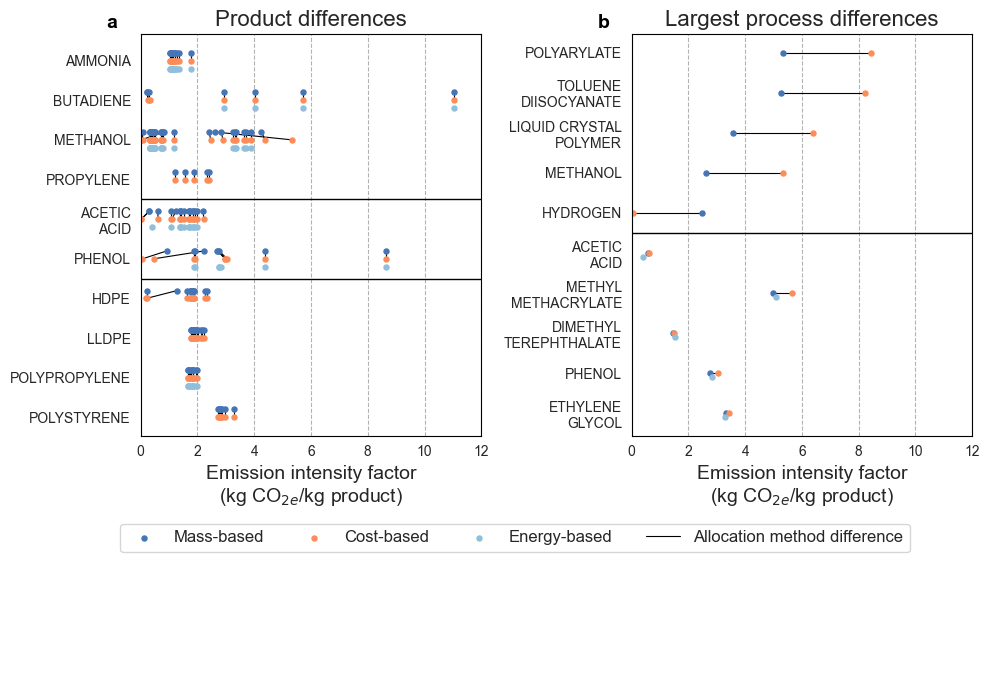

In [16]:
fig = plt.figure(figsize=[10, 7], facecolor='white')

axs = [fig.add_subplot(3,2,(1,3)), fig.add_subplot(3,2,(2,4))]

[ax.set_facecolor('white') for ax in axs]
for ax in axs:
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')

symbol_s = 13
axs[0].scatter(sample_allocs['Total_x'], sample_allocs['height']-0.2, color=colors[3], s=symbol_s, label='Mass-based', zorder=1)
axs[0].scatter(sample_allocs['Total_y'], sample_allocs['height'], color=colors[1], s=symbol_s, label='Cost-based', zorder=1)
axs[0].scatter(sample_allocs['Total'], sample_allocs['height']+0.2, color=colors[2], s=symbol_s, label='Energy-based', zorder=1)
for i, row in enumerate(sample_allocs.iloc):
    axs[0].plot([row['Total_x'], row['Total_y']], [row['height']-0.2, row['height']], color='k', linewidth=0.8, zorder=0, label='Allocation method difference' if i==0 else None)

fontsize = 14
axs[0].set_title('Product differences', fontsize=fontsize+2)
axs[0].set_yticks(range(len(sample_allocs['Product'].unique())))
axs[0].set_yticklabels(list(height_dict_sample.keys()))
axs[0].invert_yaxis()
axs[0].set_xlim([0, 12])
axs[0].set_xlabel('Emission intensity factor\n(kg CO$_{2e}$/kg product)', fontsize=fontsize)
axs[0].grid(False)
axs[0].grid(axis='x', linestyle='--', color='k', alpha=0.3)

axs[0].axhline(3.5, color='k', linewidth=1)
axs[0].axhline(5.5, color='k', linewidth=1)

axs[1].scatter(all_diffs['Total_x'], all_diffs['height'], color=colors[3], s=symbol_s, label='Mass-based', zorder=1)
axs[1].scatter(all_diffs['Total_y'], all_diffs['height'], color=colors[1], s=symbol_s, label='Cost-based', zorder=1)
axs[1].scatter(all_diffs['Total'], all_diffs['height']+0.1, color=colors[2], s=symbol_s, label='Energy-based', zorder=1)
for row in all_diffs.iloc:
    axs[1].plot([row['Total_x'], row['Total_y']], [row['height'], row['height']], color='k', linewidth=0.8, zorder=0)

fontsize = 14
axs[1].set_title('Largest process differences', fontsize=fontsize+2)
axs[1].set_yticks(range(len(all_diffs)))
axs[1].set_yticklabels(list(height_dict.keys()))
axs[1].invert_yaxis()
axs[1].set_xlim([0, 12])
axs[1].set_xlabel('Emission intensity factor\n(kg CO$_{2e}$/kg product)', fontsize=fontsize)
axs[1].grid(False)
axs[1].grid(axis='x', linestyle='--', color='k', alpha=0.3)

axs[1].axhline(4.5, color='k', linewidth=1)

#fig.suptitle('Emission factor intensity differences between allocation methods', fontsize=fontsize+4)

w, h = -0.1, 1.05
axs[0].text(w, h, 'a', transform = axs[0].transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
axs[1].text(w, h, 'b', transform = axs[1].transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})

ax_legend = fig.add_subplot(3,2,(5,6))
ax_legend.set_facecolor('white')
lines, labels = fig.axes[0].get_legend_handles_labels()
ax_legend.legend(lines, labels, loc='upper center', ncol=4, fontsize=fontsize-2, bbox_to_anchor=(0.45, 1.05))
ax_legend.axis('off')

fig.tight_layout()


In [21]:
sample_allocs[['Product', 'Total_x','Total_y','Total']].reset_index().rename(columns={'Total_x':'Mass allocation', 'Total_y':'Economic allocation', 'Total':'Energy allocation', 'index':'IHS ref'}).to_csv('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs\data_tables/fig3_a.csv')

In [30]:
all_diffs[['Product', 'Total_x','Total_y','Total']].reset_index().rename(columns={'Total_x':'Mass allocation', 'Total_y':'Economic allocation', 'Total':'Energy allocation', 'index':'IHS ref'}).to_csv('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs\data_tables/fig3_b.csv')

In [19]:
fig.savefig(output_path+'Figure_2.png', bbox_inches='tight',dpi=300)
fig.savefig(output_path+'Figure_2.eps', format='eps', bbox_inches='tight',dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## SI figures for allocation

In [38]:

primary_chems = ['AMMONIA', 'BUTADIENE', 'BENZENE', 'ETHYLENE', 'METHANOL', 'PROPYLENE', 'TOLUENE', 'MIXED\nXYLENES', 'PARA-XYLENE']
# organic_chems = ['1,4-BUTANEDIOL', '2-ETHYLHEXANOL', 'ACETALDEHYDE', 'ACETIC ACID', 'ACETONE', 'ACRYLIC ACID', 'ACRYLONITRILE', 'ADIPIC ACID', 'ADIPONITRILE', 'ANILINE', 'CAPROLACTAM', 'CYCLOHEXANE', 'EPICHLORODRIN', 'ETHANOLAMINES', 'ETHYLBENZENE'']
fertilisers = ['AMMONIUM NITRATE', 'AMMONIUM SULPHATE', 'CALCIUM AMMONIUM NITRATE', 'UREA']
plastics = ['ABS', 'HDPE', 'LDPE', 'LLDPE', 'PET', 'POLYESTER\nPOLYMER', 'POLYPROPYLENE', 'POLYSTYRENE', 'PVC']#'EXPANDABLE PS',
thermosets = ['ACRYLIC ACID ESTERS', 'BUTYL RUBBER', 'EPOXY RESINS', 'POLYAMIDE FIBRES', 'POLYBUTADIENE', 'POLYESTER FIBRES', 'POLYESTER FILM', 'POLYETHER POLYOLS', 'POLYMETHYL METHACRYLATE', 'SBR (Includes SBCs)', 'VINYL ACETATE M.', 'SAN']
solvents = ['BUTYL ACETATE', 'ISOBUTANOL', 'ISOPROPANOL', 'LUBE', 'N-BUTANOL']
others = ['BUTYL RUBBER', 'EPOXY NOVOLAC RESIN, ECN', 'AMMONIA SULPHATE', 'DMT', 'POLYBUTADIENE', 'ISOPROPANOL', 'N-BUTANOL', 'UREA', 'POLYBUTADIENE']

In [39]:
mass_efs = get_allocation_totals(grouped_emissions, gas, 'mass')
energy_efs = get_allocation_totals(grouped_emissions, gas, 'energy')
economic_efs = get_allocation_totals(grouped_emissions, gas, 'economic')

merged_efs = mass_efs[['Product', 'ihs_match', 'Total']].merge(economic_efs[['Product', 'ihs_match', 'Total']], on=['Product', 'ihs_match'], how='outer').merge(energy_efs[['Product', 'ihs_match', 'Total']], on=['Product', 'ihs_match'], how='outer')
merged_efs['Diff'] = abs(merged_efs['Total_x']- merged_efs['Total_y'])
merged_efs['Energy_diff'] = abs(merged_efs['Total_x']-merged_efs['Total'])

eco_diffs = merged_efs.sort_values('Diff', ascending=False).drop_duplicates('Product')
energy_diff = merged_efs.sort_values('Energy_diff', ascending=False).dropna(subset=['Total']).drop_duplicates('Product')
all_diffs = pd.concat((eco_diffs, energy_diff))

# all_diffs['Product'] = all_diffs['Product'].str.replace(' ', '\n').str.replace('LIQUID\nCRYSTAL\nPOLYMER,\nNEAT', 'LIQUID CRYSTAL\nPOLYMER')

height_dict = dict(zip(all_diffs['Product'].unique(), range(len(all_diffs['Product'].unique()))))

all_diffs['height'] = all_diffs['Product'].replace(height_dict)
allocs_prim = merged_efs[[i in primary_chems for i in merged_efs['Product']]]
allocs_org = merged_efs[[i.replace('\n', ' ') in organic_chems for i in merged_efs['Product']]]
#allocs_fert = merged_efs[[i.replace('\n', ' ') in fertilisers for i in merged_efs['Product']]]
allocs_tps = merged_efs[[i.replace('\n', ' ') in plastics for i in merged_efs['Product']]]
# allocs_ts = merged_efs[[i.replace('\n', ' ') in thermosets for i in merged_efs['Product']]]
# allocs_sv = merged_efs[[i.replace('\n', ' ') in solvents for i in merged_efs['Product']]]
allocs_others = merged_efs[[i.replace('\n', ' ') in all_ds for i in merged_efs['Product']]]

/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_16154/3735777062.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  efs['Total'] = efs[efs.columns[2:]].sum(axis=1)
/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_16154/3735777062.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  efs['Total'] = efs[efs.columns[2:]].sum(axis=1)
/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_16154/3735777062.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_16154/1255731092.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_allocs['height'] = sample_allocs['Product'].replace(height_dict_sample)
/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_16154/1255731092.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_allocs['height'] = sample_allocs['Product'].replace(height_dict_sample)
/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_16154/1255731092.py:8: SettingWithCopyW

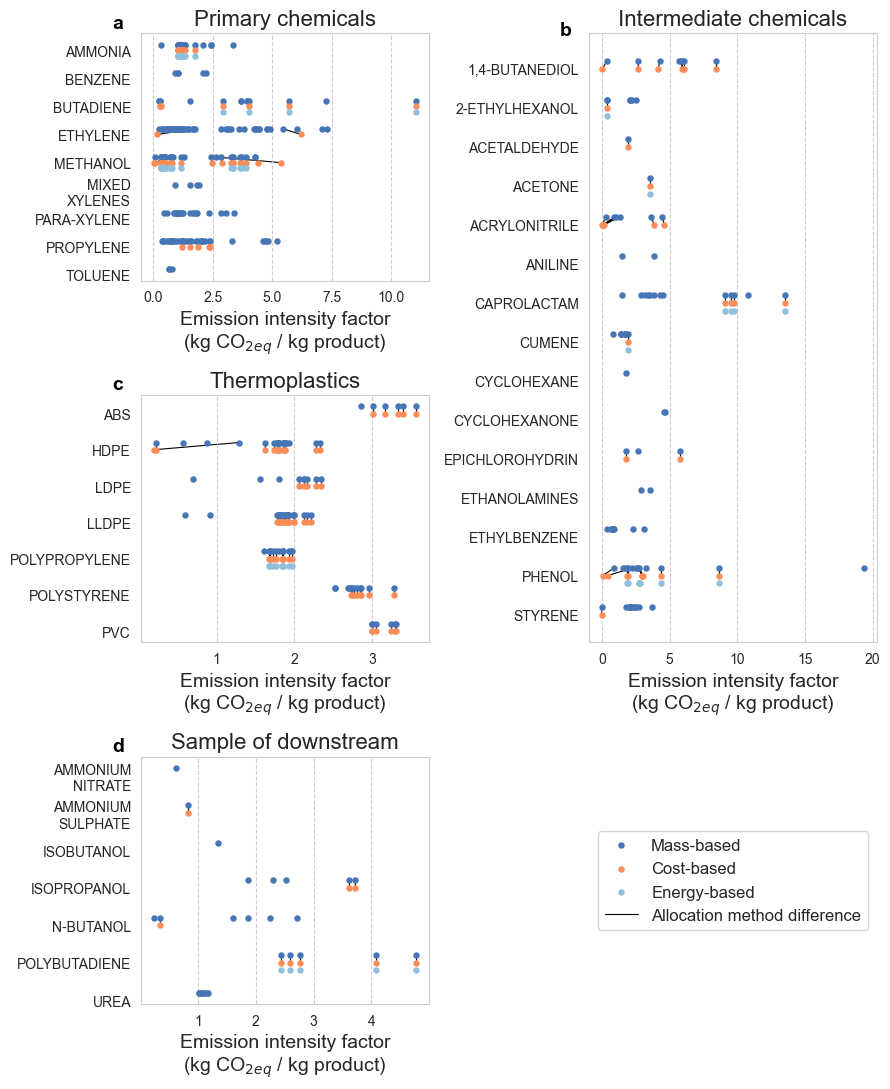

In [40]:
fig = plt.figure(figsize=[9, 11], facecolor='white')

axs = [fig.add_subplot(3,2,1), fig.add_subplot(3,2,(2,4)), fig.add_subplot(3,2,3), fig.add_subplot(3,2,5)]
titles = ['Primary chemicals', 'Intermediate chemicals', 'Thermoplastics', 'Sample of downstream']

for ax, sample_allocs, title in zip(axs, [allocs_prim, allocs_org, allocs_tps, allocs_others], titles):
    height_dict_sample = dict(zip(sample_allocs['Product'].unique(), range(len(sample_allocs['Product'].unique()))))
    sample_allocs['height'] = sample_allocs['Product'].replace(height_dict_sample)

    symbol_s = 13
    ax.scatter(sample_allocs['Total_x'], sample_allocs['height']-0.2, color=colors[3], s=symbol_s, label='Mass-based', zorder=1)
    ax.scatter(sample_allocs['Total_y'], sample_allocs['height'], color=colors[1], s=symbol_s, label='Cost-based', zorder=1)
    ax.scatter(sample_allocs['Total'], sample_allocs['height']+0.2, color=colors[2], s=symbol_s, label='Energy-based', zorder=1)
    for i, row in enumerate(sample_allocs.iloc):
        ax.plot([row['Total_x'], row['Total_y']], [row['height']-0.2, row['height']], color='k', linewidth=0.8, zorder=0, label='Allocation method difference' if i==0 else None)

    fontsize = 14
    ax.set_title(title, fontsize=fontsize+2)
    ax.set_yticks(range(len(sample_allocs['Product'].unique())))
    ax.set_yticklabels(list(height_dict_sample.keys()))
    ax.invert_yaxis()
    #ax.set_xlim([0, 12])
    ax.set_xlabel('Emission intensity factor\n(kg CO$_{2eq}$ / kg product)', fontsize=fontsize)
    ax.grid(False)
    ax.grid(axis='x', linestyle='--')

# axs[1].scatter(all_diffs['Total_x'], all_diffs['height'], color=colors[3], s=symbol_s, label='Mass-based', zorder=1)
# axs[1].scatter(all_diffs['Total_y'], all_diffs['height'], color=colors[1], s=symbol_s, label='Cost-based', zorder=1)
# axs[1].scatter(all_diffs['Total'], all_diffs['height']+0.1, color=colors[2], s=symbol_s, label='Energy-based', zorder=1)
# for row in all_diffs.iloc:
#     axs[1].plot([row['Total_x'], row['Total_y']], [row['height'], row['height']], color='k', linewidth=0.8, zorder=0)
#
# fontsize = 14
# axs[1].set_title('Largest process differences', fontsize=fontsize+2)
# axs[1].set_yticks(range(len(all_diffs)))
# axs[1].set_yticklabels(list(height_dict.keys()))
# axs[1].invert_yaxis()
# axs[1].set_xlim([0, 12])
# axs[1].set_xlabel('Emission intensity factor\n(kg CO$_{2eq}$ / kg product)', fontsize=fontsize)
# axs[1].grid(axis='x', linestyle='--')
#
# axs[1].axhline(4.5, color='k', linewidth=1)

#fig.suptitle('Emission factor intensity differences between allocation methods', fontsize=fontsize+4)

w, h = -0.1, 1.05
axs[0].text(w, h+0.03, 'a', transform = axs[0].transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
axs[1].text(w, h-0.03, 'b', transform = axs[1].transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
axs[2].text(w, h+0.03, 'c', transform = axs[2].transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
axs[3].text(w, h+0.03, 'd', transform = axs[3].transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})



ax_legend = fig.add_subplot(3,2,(6))
lines, labels = fig.axes[0].get_legend_handles_labels()
ax_legend.legend(lines, labels, loc='center', ncol=1, fontsize=fontsize-2)#, bbox_to_anchor=(0.45, 1.05))
ax_legend.axis('off')

fig.tight_layout()


In [43]:
fig.savefig(output_path+'Figure_S3.png', bbox_inches='tight',dpi=300)
fig.savefig(output_path+'Figure_S3.eps', format='eps', bbox_inches='tight',dpi=300)

#fig.savefig(output_path+'allocation_SI.png', bbox_inches='tight',dpi=150)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## Create conversion factor plot

C:\Users\lukec\AppData\Local\Temp/ipykernel_6032/484399870.py:53: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  axs.barh(ihs_mins.index.values, merged_limits.max(axis=1)-merged_limits.min(axis=1), left=merged_limits.min(axis=1), color='grey', alpha=0.15, label='Range of EFs')


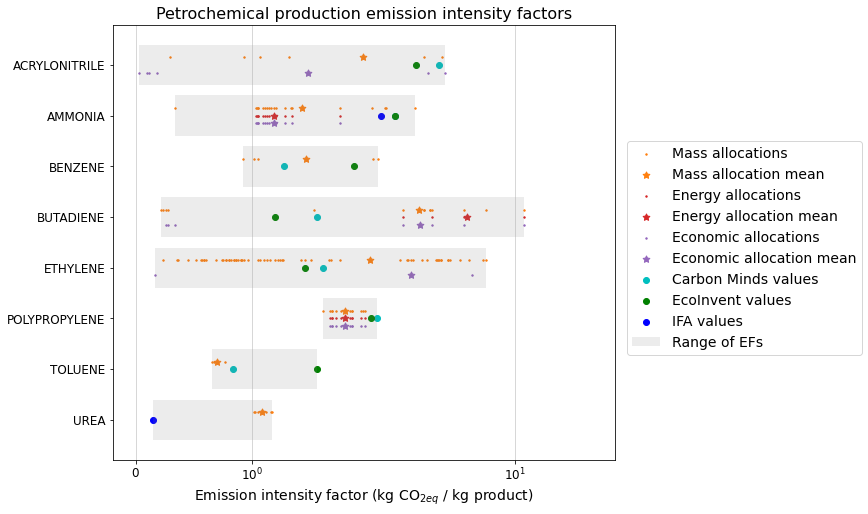

In [129]:
# Conversion factor plot

## Inputs
gas = 'CO2e_100a'
ihs_property = 'ihs_cradle-to-out-gate '
allocations = ['mass', 'energy', 'economic']
take_chemicals = ['ACETIC ACID', 'ACRYLONITRILE', 'AMMONIA', 'POLYPROPYLENE', 'PROPYLENE OXIDE', 'ETHYLENE', 'BUTADIENE', 'BENZENE', 'TOLUENE', 'METHYL METHACRYLATE', 'NYLON 6 CHIPS', 'NYLON 66 RESIN', 'P-XYLENE', 'POLYETHYLENE TEREPHTHALATE', 'POLYETHYLENE, llD', 'POLYETHYLENE, LD', 'UREA']#False
sample_size = 100
plt.rcParams.update({'font.size': 12})

## Get appropriate data
pe = grouped_emissions.copy()
pe = pe[['Product','ihs_match']+list(pe.columns[[gas in col for col in pe.columns]])]

if take_chemicals:
    pe = pe[[i in take_chemicals for i in pe['Product']]]
    fig, axs = plt.subplots(1,1, figsize=[9,8], facecolor='white')
else: fig, axs = plt.subplots(1,1, figsize=[10,50], facecolor='white')

## Loop over allocation types for averages and scatter
ihs_vals = pd.DataFrame()
## Plot IHS values
for i, (alloc, color) in enumerate(zip(allocations, ['C1', 'C3', 'C4'])):

    column = ihs_property+gas+', '+alloc+' allocation factor'
    alloc_df = pe[['Product', 'ihs_match', column]].rename(columns={column:'conv_factor'})
    alloc_df['Allocation'] = alloc
    ihs_vals = pd.concat((ihs_vals, alloc_df))
    globals()[alloc+'avg'] = pe.groupby('Product').mean()[column]

    alloc_data = ihs_vals[ihs_vals['Allocation'] == alloc]
    height_dict = dict(zip(alloc_data['Product'].unique(), range(len(alloc_data['Product'].unique()))))

    axs.scatter(alloc_data['conv_factor'], alloc_data['Product'].replace(height_dict)-0.15+(i*0.15), color=color, s=2, label=alloc.title() +' allocations')
    axs.scatter(globals()[alloc+'avg'], np.arange(0, len(alloc_data['Product'].unique()))-0.15+(i*0.15), color=color, s=50, marker=(5, 1), label=alloc.title() +' allocation mean')

## Get single values
ihs_mins = ihs_vals.groupby('Product').min()['conv_factor']
ihs_maxs = ihs_vals.groupby('Product').max()['conv_factor']
cm_vals = pe.groupby('Product').max()['cm_'+gas+'_conv_factor']
ei_vals = pe.groupby('Product').max()['ei_'+gas+'_conv_factor']
if gas == 'CO2e_100a':
    ifa_vals = pe.groupby('Product').max()['ifa_'+gas+'_CtOG factor']

## Plot CM & EI values
axs.scatter(cm_vals, np.arange(0, len(cm_vals)), color='c', label='Carbon Minds values')
axs.scatter(ei_vals, np.arange(0, len(cm_vals)), color='g', label='EcoInvent values')
if gas == 'CO2e_100a':
    axs.scatter(ifa_vals, np.arange(0, len(cm_vals)), color='b', label='IFA values')

merged_limits = ihs_mins.reset_index().merge(ei_vals.reset_index()).merge(cm_vals.reset_index()).merge(ifa_vals.reset_index()).merge(ihs_maxs.reset_index().rename(columns={'conv_factor':'maxs'}))

axs.barh(ihs_mins.index.values, merged_limits.max(axis=1)-merged_limits.min(axis=1), left=merged_limits.min(axis=1), color='grey', alpha=0.15, label='Range of EFs')


fontsize = 14
axs.set_title('Petrochemical production emission intensity factors', fontsize=fontsize+2)
axs.invert_yaxis()
axs.set_xscale('symlog')
axs.set_xlim([-0.2, 30])
axs.set_xlabel('Emission intensity factor (kg CO$_{2eq}$ / kg product)', fontsize=fontsize)
axs.grid(which='both', axis='x', linestyle='-', linewidth=0.5)
axs.legend(bbox_to_anchor=(1.01, 0.75), fontsize=fontsize)

In [11]:
# Save output plot
fig.savefig(output_path+'collapsed_conversion_factor_comparison.png', bbox_inches='tight')

In [65]:
ems_tot = grouped_emissions[['Direct Utilities CO2e_100a, mass allocation factor', 'Indirect Utilities CO2e_100a, mass allocation factor', 'Direct Process CO2e_100a, mass allocation factor', 'Feedstock CO2e_100a, mass allocation factor']].sum().reset_index()
ems_tot['perc'] = ems_tot[0]/ems_tot[0].sum()

In [71]:
merged = ems_tot.reset_index().merge(sig_tot.reset_index(), on='level_0')
merged['error_perc'] = merged['0_y']/merged['0_x']

In [67]:
sig_tot = grouped_emissions[['Direct Utilities CO2e_100a, mass allocation sigma', 'Indirect Utilities CO2e_100a, mass allocation sigma', 'Direct Process CO2e_100a, mass allocation sigma', 'Feedstock CO2e_100a, mass allocation sigma']].sum().reset_index()
sig_tot['perc'] = sig_tot[0]/sig_tot[0].sum()

In [72]:
merged

,level_0,index_x,0_x,perc_x,index_y,0_y,perc_y,error_perc
0,0,"Direct Utilities CO2e_100a, mass allocation fa...",218.889213,0.029380,"Direct Utilities CO2e_100a, mass allocation sigma",21.139556,0.020459,0.096577
1,1,"Indirect Utilities CO2e_100a, mass allocation ...",2632.815146,0.353385,"Indirect Utilities CO2e_100a, mass allocation ...",410.577124,0.397351,0.155946
2,2,"Direct Process CO2e_100a, mass allocation factor",783.644329,0.105183,"Direct Process CO2e_100a, mass allocation sigma",15.826195,0.015316,0.020196
3,3,"Feedstock CO2e_100a, mass allocation factor",3814.935610,0.512052,"Feedstock CO2e_100a, mass allocation sigma",585.743121,0.566874,0.153539


In [26]:
breakdown

,ihs_match,Feedstock,Indirect Energy Use,Direct Energy Use,Direct Process
Type,,,,,
Crude,P-XYLENE FROM ZHEJIANG REFINERY COMPLEX,0.762630,0.104740,0.000000,NaN
Crude,P-XYLENE FROM SHENGHONG CRUDE OIL TO CHEMICALS,1.111519,0.000000,0.000000,NaN
Crude,P-XYLENE FROM HENGLI REFINERY COMPLEX,0.815238,0.426627,0.277827,NaN
Naphtha,P-XYLENE FROM HEAVY NAPHTHA,0.182859,0.141356,0.264902,NaN
Naphtha,P-XYLENE BY AXENS PARAMAX PROCESS FROM HEAVY N...,0.452683,1.258046,0.000000,NaN
Reformate,P-XYLENE FROM REFORMATE II,0.375699,0.052202,0.026006,NaN
Reformate,P-XYLENE BY CRYSTALLIZATION PROCESS,0.419124,0.319123,0.145383,NaN
Reformate,P-XYLENE BY COMBINED CRYSTALLIZATION/ADSORPTIO...,0.417311,0.346908,0.190805,NaN
Reformate,P-XYLENE BY ADSORPTION PROCESS CASE A- STDP XY...,0.417509,0.358855,0.193203,NaN


## Methanol

In [66]:
gas = 'CO2e_100a'
plot_product = 'METHANOL'
exclude = 'METHANOL FROM BITUMINOUS COAL'

prod = grouped_emissions[grouped_emissions['Product'] == plot_product]

alloc = 'mass'

total_col = 'ihs_cradle-to-out-gate '+gas+', '+alloc+' allocation '

eth_types = pd.read_csv(input_path+'extra_inputs/ML_cats.csv', index_col=0)
prod_types = prod.merge(eth_types, on='ihs_match').sort_values(['Type', total_col+'factor'], ascending=True)

prod_types = prod_types[prod_types['ihs_match']!=exclude]

total = prod_types[[total_col+'factor', total_col+'sigma']]
properties = stages_used#

breakdown = prod_types[['Type', 'ihs_match']+[prop+' '+gas+', '+alloc+' allocation factor' for prop in properties]].set_index(['Type'])
breakdown.rename(columns=dict(zip([prop+' '+gas+', '+alloc+' allocation factor' for prop in properties], properties)), inplace=True)

breakdown['Feedstock'] = np.sum(breakdown[['Feedstock', 'Primary chemicals', 'Organic chemicals', 'Other intermediates']], axis=1)
properties = ['Feedstock', 'Indirect Utilities', 'Direct Utilities', 'Direct Process']
breakdown = breakdown[['ihs_match']+properties]

breakdown.rename(columns={'Indirect Utilities':'Indirect Energy Use', 'Direct Utilities': 'Direct Energy Use'}, inplace=True)


breakdown = breakdown[breakdown['ihs_match']!=exclude]

In [9]:
breakdown.reset_index().fillna(0).drop(columns=['ihs_match']).reset_index().merge(total.reset_index(drop=True).reset_index(), on='index').drop(columns=['index']).rename(columns={'ihs_cradle-to-out-gate CO2e_100a, mass allocation factor':'Total', 'ihs_cradle-to-out-gate CO2e_100a, mass allocation sigma':'Total uncertainty'}).to_csv('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs\data_tables/fig4_b.csv')

In [11]:
# df_tot = pd.DataFrame()
# for prop in  ['Natural Gas', 'Syngas', 'Wood', 'Recycled plastic', 'Coke oven gas', 'Carbon dioxide', 'Coal',  'Other']:
#     if prop in ['Carbon dioxide', 'Recycled plastic', 'Wood']:
#         df = pd.DataFrame(breakdown.loc[prop]).transpose()
#     else: df = breakdown.loc[prop]    
#     df_tot = pd.concat((df_tot, df))

In [16]:
breakdown['ihs_match'].reset_index().to_csv('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs/ML_numbers.csv')

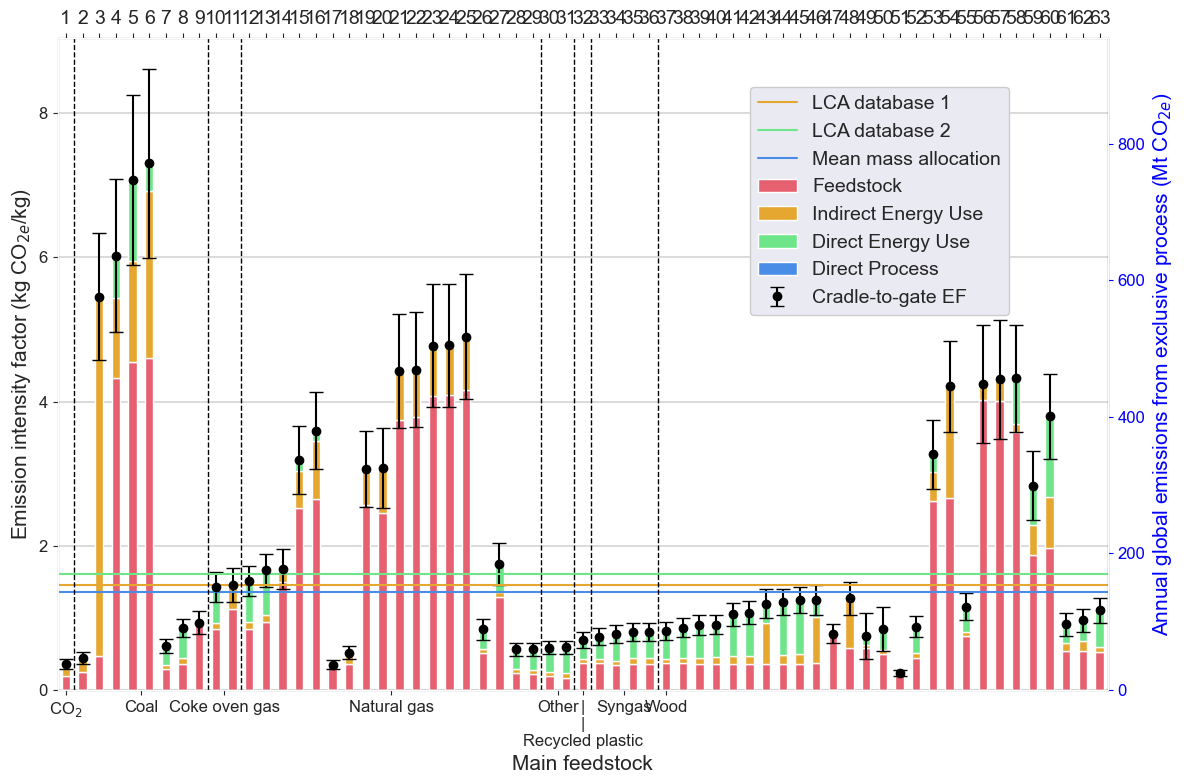

In [85]:
colors = ['#E66070', '#E6A730','#6EE588','#498DE6','#A055E6']+['pink']

eth_production = 105.6
fontsize = 15

plt.rcParams['font.size'] = 12
#sns.set(font_scale=1.5)

fig, ax = plt.subplots(figsize=[12,8], facecolor='white')

ax.set_facecolor('white')
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')

breakdown.plot.bar(stacked=True, ax=ax, alpha=1,color=colors)
ax.grid(False)
ax.grid(which='major', axis='y', linestyle='-', color='k', linewidth=0.2, alpha=1)
ax.set_axisbelow(True)

ax.errorbar(range(len(total)), total[total.columns[0]], yerr=(total.min(axis=1), total[total.columns[1]]), fmt='o', color='black', ecolor='k', capsize=5, label='Cradle-to-gate EF')
ax.axhline(prod['ei_CO2e_100a_conv_factor'].unique(), label='LCA database 1', color=colors[1], alpha=1)
ax.axhline(prod['cm_CO2e_100a_conv_factor'].unique(), label='LCA database 2', color=colors[2], alpha=1)
ax.axhline(1.352086776677054, label='Mean mass allocation', color=colors[3], alpha=1)

ax.set_ylabel('Emission intensity factor (kg CO$_{2e}$/kg)', fontsize=fontsize)
ax.set_xlabel('Main feedstock', fontsize=fontsize)
ax.get_legend().remove()

ax2 = ax.twinx()
ax2.grid(False)
ax2.set_axisbelow(True)
ax2.set_ylabel('Annual global emissions from exclusive process (Mt CO$_{2e}$)', fontsize=fontsize, color='blue')
ax2.tick_params(axis='y', labelcolor='blue', color='blue')
ax2.spines['right'].set_color('blue')

# Set the limits of the secondary y-axis to be a multiple of the primary y-axis
y1_min, y1_max = ax.get_ylim()
y2_min, y2_max = y1_min * eth_production, y1_max * eth_production
ax2.set_ylim(y2_min, y2_max)
#ax.set_title("Emission intensity factors from Ethylene production", fontsize=fontsize+2)

boundaries = [0.5, 8.5, 10.5, 28.5, 30.5, 31.5, 35.5]
ticks = [0, 4.5, 9.5, 19.5,29.5,31,33.5, 36]
tick_labels = ['CO$_{2}$', 'Coal', 'Coke oven gas', 'Natural gas', 'Other', '|\n|\nRecycled plastic','Syngas', 'Wood']#  'Toluene']

ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels, rotation=0)

for location in boundaries:
    ax.axvline(location, color='k', linestyle='--', linewidth=1)

# done=0
# for num, label in enumerate(tick_labels):
#     if label in used_convs.index:
#         value = used_convs.loc[label]['value']
#         err = used_convs.loc[label]['error']
#         ax.plot([boundaries[num-1], boundaries[num]], [value, value], 'k--', linewidth=1, alpha=0.8, label='Feedstock specific' if done==0 else None)
#         done=1
#         ax.fill_between([boundaries[num-1], boundaries[num]], [max(value-err,0), max(value-err,0)], [value+err, value+err], color='k', alpha=0.1)
ax2 = ax.twiny()
ax2.grid(False)
ax2.set_axisbelow(True)
ax2.set_xticks([i+0.5 for i in list(range(0, len(breakdown)))], labels=range(1, len(breakdown)+1), fontsize=fontsize-1)
ax2.set_xlim([0, len(breakdown)])
ax.legend(fontsize=fontsize-1, framealpha=1, fancybox=True, bbox_to_anchor=[0.65,0.56])#loc='upper center')

fs = 18
h = 1.1
w = 0
axs[0].text(w, h, 'a', transform = axs[0].transAxes, fontsize=fs, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})

axs[1].text(w, h, 'a', transform = axs[1].transAxes, fontsize=fs, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})

fig.tight_layout()

In [149]:
# Save output plot
fig.savefig(output_path+'Figure4_methanol.png', bbox_inches='tight', dpi=150)

## Para-Xylene plot

In [79]:
gas = 'CO2e_100a'
plot_product = 'PARA-XYLENE'
exclude = 'P-XYLENE FROM SHENGHONG CRUDE OIL TO CHEMICALS'

prod = grouped_emissions[grouped_emissions['Product'] == plot_product]

alloc = 'mass'

total_col = 'ihs_cradle-to-out-gate '+gas+', '+alloc+' allocation '

eth_types = pd.read_csv(input_path+'extra_inputs/PX_cats.csv', index_col=0)
prod_types = prod.merge(eth_types, on='ihs_match').sort_values(['Type', total_col+'factor'], ascending=True)

prod_types = prod_types[prod_types['ihs_match']!=exclude]

total = prod_types[[total_col+'factor', total_col+'sigma']]
properties = stages_used#

breakdown = prod_types[['Type', 'ihs_match']+[prop+' '+gas+', '+alloc+' allocation factor' for prop in properties]].set_index(['Type'])
breakdown.rename(columns=dict(zip([prop+' '+gas+', '+alloc+' allocation factor' for prop in properties], properties)), inplace=True)

breakdown['Feedstock'] = np.sum(breakdown[['Feedstock', 'Primary chemicals', 'Organic chemicals', 'Other intermediates']], axis=1)
properties = ['Feedstock', 'Indirect Utilities', 'Direct Utilities', 'Direct Process']
breakdown = breakdown[['ihs_match']+properties]

breakdown.rename(columns={'Indirect Utilities':'Indirect Energy Use', 'Direct Utilities': 'Direct Energy Use'}, inplace=True)


breakdown = breakdown[breakdown['ihs_match']!=exclude]

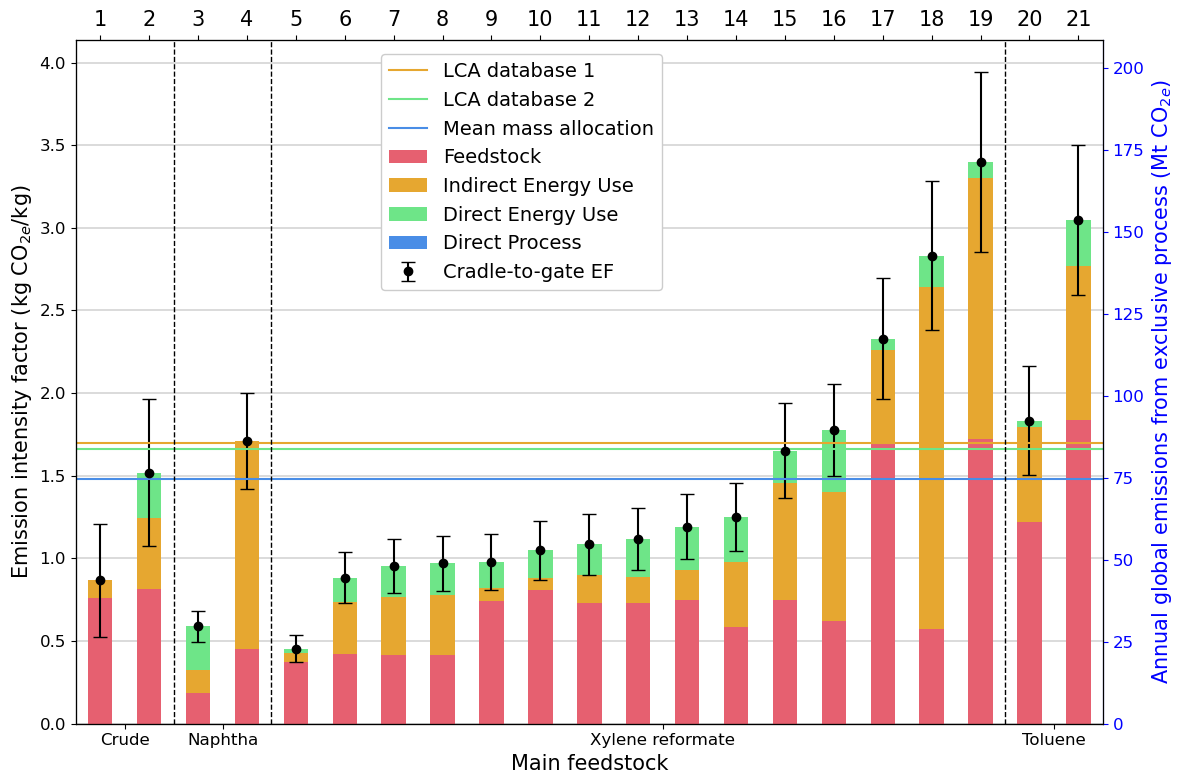

In [80]:
colors = ['#E66070', '#E6A730','#6EE588','#498DE6','#A055E6']+['pink']

eth_production = 50.4
fontsize = 15

plt.rcParams['font.size'] = 12
#sns.set(font_scale=1.5)

fig, ax = plt.subplots(figsize=[12,8], facecolor='white')

breakdown.plot.bar(stacked=True, ax=ax, alpha=1,color=colors)

ax.grid(which='major', axis='y', linestyle='-', color='k', linewidth=0.2, alpha=1)
ax.set_axisbelow(True)

ax.errorbar(range(len(total)), total[total.columns[0]], yerr=(total.min(axis=1), total[total.columns[1]]), fmt='o', color='black', ecolor='k', capsize=5, label='Cradle-to-gate EF')
ax.axhline(prod['ei_CO2e_100a_conv_factor'].unique()[1], label='LCA database 1', color=colors[1], alpha=1)
ax.axhline(prod['cm_CO2e_100a_conv_factor'].unique()[1], label='LCA database 2', color=colors[2], alpha=1)
ax.axhline(1.4817977799249484, label='Mean mass allocation', color=colors[3], alpha=1)

ax.set_ylabel('Emission intensity factor (kg CO$_{2e}$/kg)', fontsize=fontsize)
ax.set_xlabel('Main feedstock', fontsize=fontsize)
ax.get_legend().remove()

ax2 = ax.twinx()
ax2.set_ylabel('Annual global emissions from exclusive process (Mt CO$_{2e}$)', fontsize=fontsize, color='blue')
ax2.tick_params(axis='y', labelcolor='blue', color='blue')
ax2.spines['right'].set_color('blue')

# Set the limits of the secondary y-axis to be a multiple of the primary y-axis
y1_min, y1_max = ax.get_ylim()
y2_min, y2_max = y1_min * eth_production, y1_max * eth_production
ax2.set_ylim(y2_min, y2_max)
#ax.set_title("Emission intensity factors from Ethylene production", fontsize=fontsize+2)

boundaries = [1.5, 3.5, 18.5]
ticks = [0.5, 2.5, 11.5, 19.5]
tick_labels = ['Crude', 'Naphtha', 'Xylene reformate', 'Toluene']

ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels, rotation=0)

for location in boundaries:
    ax.axvline(location, color='k', linestyle='--', linewidth=1)

# done=0
# for num, label in enumerate(tick_labels):
#     if label in used_convs.index:
#         value = used_convs.loc[label]['value']
#         err = used_convs.loc[label]['error']
#         ax.plot([boundaries[num-1], boundaries[num]], [value, value], 'k--', linewidth=1, alpha=0.8, label='Feedstock specific' if done==0 else None)
#         done=1
#         ax.fill_between([boundaries[num-1], boundaries[num]], [max(value-err,0), max(value-err,0)], [value+err, value+err], color='k', alpha=0.1)
ax2 = ax.twiny()
ax2.set_xticks([i+0.5 for i in list(range(0, len(breakdown)))], labels=range(1, len(breakdown)+1), fontsize=fontsize)
ax2.set_xlim([0, 21])
ax.legend(fontsize=fontsize-1, framealpha=1, fancybox=True, bbox_to_anchor=[0.58,0.62])#loc='upper center')

fig.tight_layout()

## Split emissions plot

In [80]:
gas = 'CO2e_100a'
plot_product = 'ETHYLENE'
exclude = 'ETHYLENE FROM ATMOSPHERIC GAS OIL BY MILLISECOND(TM) CRACKING/DEMETHANIZATION'

prod = grouped_emissions[grouped_emissions['Product'] == plot_product]

alloc = 'mass'

total_col = 'ihs_cradle-to-out-gate '+gas+', '+alloc+' allocation '

eth_types = pd.read_csv(input_path+'extra_inputs/ethylene_groups.csv', index_col=0)
prod_types = prod.merge(eth_types, on='ihs_match').sort_values(['Type', total_col+'factor'], ascending=True)

prod_types = prod_types[prod_types['ihs_match']!=exclude]

total = prod_types[[total_col+'factor', total_col+'sigma']]
properties = stages_used#

breakdown = prod_types[['Type', 'ihs_match']+[prop+' '+gas+', '+alloc+' allocation factor' for prop in properties]].set_index(['Type'])
breakdown.rename(columns=dict(zip([prop+' '+gas+', '+alloc+' allocation factor' for prop in properties], properties)), inplace=True)

breakdown['Feedstock'] = np.sum(breakdown[['Feedstock', 'Primary chemicals', 'Organic chemicals', 'Other intermediates']], axis=1)
properties = ['Feedstock', 'Indirect Utilities', 'Direct Utilities', 'Direct Process']
breakdown = breakdown[['ihs_match']+properties]

breakdown.rename(columns={'Indirect Utilities':'Indirect Energy Use', 'Direct Utilities': 'Direct Energy Use'}, inplace=True)


breakdown = breakdown[breakdown['ihs_match']!=exclude]

In [19]:
breakdown['ihs_match'].reset_index().to_csv('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs/eth_numbers.csv')

In [9]:
breakdown.reset_index().fillna(0).drop(columns=['ihs_match']).reset_index().merge(total.reset_index(drop=True).reset_index(), on='index').drop(columns=['index']).rename(columns={'ihs_cradle-to-out-gate CO2e_100a, mass allocation factor':'Total', 'ihs_cradle-to-out-gate CO2e_100a, mass allocation sigma':'Total uncertainty'}).to_csv('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs\data_tables/fig4.csv')

In [83]:
used_convs = pd.read_csv(input_path+'processed/ethylene_conversion_factors.csv')[['Feedstock', 'ihs_cradle-to-out-gate CO2e_100a,  allocation factor', 'ihs_cradle-to-out-gate CO2e_100a,  allocation sigma']].rename(columns={'ihs_cradle-to-out-gate CO2e_100a,  allocation factor':'value', 'ihs_cradle-to-out-gate CO2e_100a,  allocation sigma':'error'})
used_convs['Feedstock'] = used_convs['Feedstock'].str.title().replace({'Lpg':'|\nNatural\ngas', 'Mid-Dist':'Methanol', 'Others':'Other', 'Vacuum':'Vacuum\ngas oil'})
used_convs.set_index('Feedstock', inplace=True)

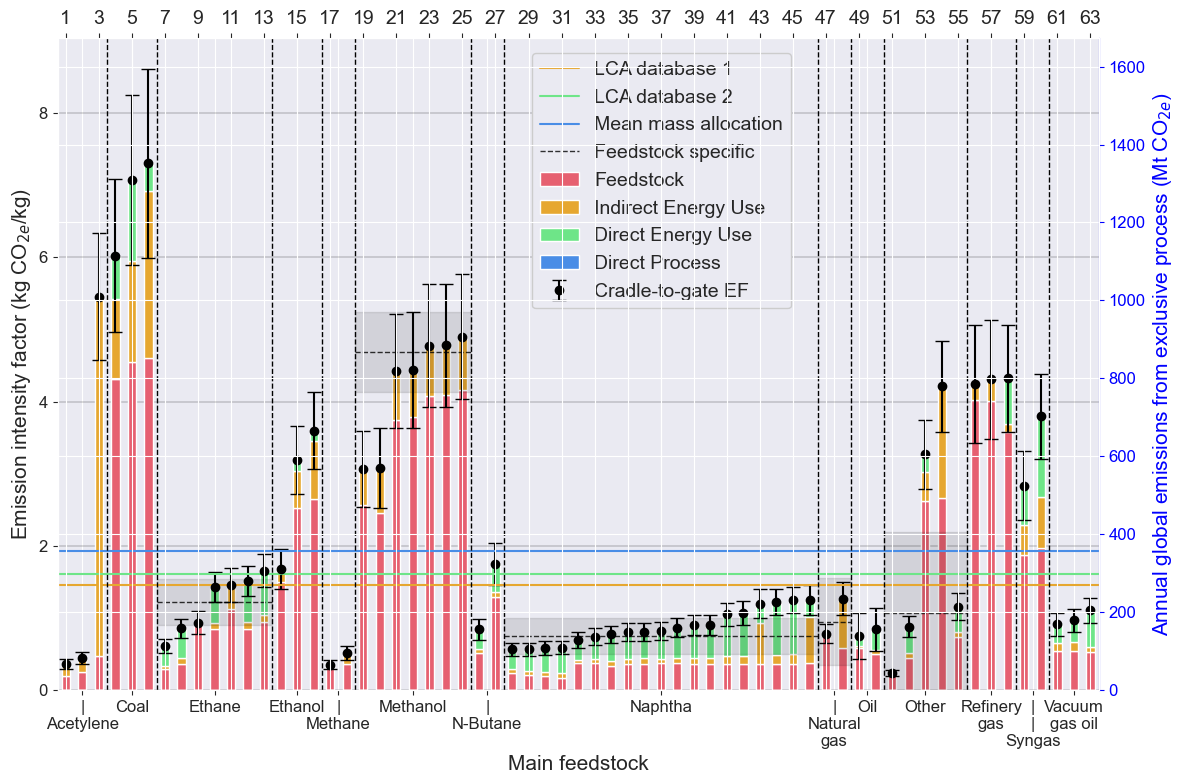

In [84]:
colors = ['#E66070', '#E6A730','#6EE588','#498DE6','#A055E6']+['pink']

eth_production = 185
fontsize = 15

plt.rcParams['font.size'] = 12
#sns.set(font_scale=1.5)

fig, ax = plt.subplots(figsize=[12,8], facecolor='white')

breakdown.plot.bar(stacked=True, ax=ax, alpha=1,color=colors)

ax.grid(which='major', axis='y', linestyle='-', color='k', linewidth=0.2, alpha=1)
ax.set_axisbelow(True)

ax.errorbar(range(len(total)), total[total.columns[0]], yerr=(total.min(axis=1), total[total.columns[1]]), fmt='o', color='black', ecolor='k', capsize=5, label='Cradle-to-gate EF')
ax.axhline(prod['ei_CO2e_100a_conv_factor'].unique(), label='LCA database 1', color=colors[1], alpha=1)
ax.axhline(prod['cm_CO2e_100a_conv_factor'].unique(), label='LCA database 2', color=colors[2], alpha=1)
ax.axhline(1.931873, label='Mean mass allocation', color=colors[3], alpha=1)

ax.set_ylabel('Emission intensity factor (kg CO$_{2e}$/kg)', fontsize=fontsize)
ax.set_xlabel('Main feedstock', fontsize=fontsize)
ax.get_legend().remove()

ax2 = ax.twinx()
ax2.set_ylabel('Annual global emissions from exclusive process (Mt CO$_{2e}$)', fontsize=fontsize, color='blue')
ax2.tick_params(axis='y', labelcolor='blue', color='blue')
ax2.spines['right'].set_color('blue')

# Set the limits of the secondary y-axis to be a multiple of the primary y-axis
y1_min, y1_max = ax.get_ylim()
y2_min, y2_max = y1_min * eth_production, y1_max * eth_production
ax2.set_ylim(y2_min, y2_max)
#ax.set_title("Emission intensity factors from Ethylene production", fontsize=fontsize+2)

boundaries = [2.5, 5.5, 12.5, 15.5, 17.5, 24.5, 26.5, 45.5, 47.5, 49.5, 54.5, 57.5, 59.5]
ticks = [1,4,9,14,16.5,21,25.5,36,46.5,48.5,52,56,58.5,61]
tick_labels = ['|\nAcetylene', 'Coal', 'Ethane', 'Ethanol', '|\nMethane', 'Methanol', '|\nN-Butane', 'Naphtha', '|\nNatural\ngas', 'Oil', 'Other', 'Refinery\ngas', '|\n|\nSyngas', 'Vacuum\ngas oil']

ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels, rotation=0)

for location in boundaries:
    ax.axvline(location, color='k', linestyle='--', linewidth=1)

done=0
for num, label in enumerate(tick_labels):
    if label in used_convs.index:
        value = used_convs.loc[label]['value']
        err = used_convs.loc[label]['error']
        ax.plot([boundaries[num-1], boundaries[num]], [value, value], 'k--', linewidth=1, alpha=0.8, label='Feedstock specific' if done==0 else None)
        done=1
        ax.fill_between([boundaries[num-1], boundaries[num]], [max(value-err,0), max(value-err,0)], [value+err, value+err], color='k', alpha=0.1)

ax2 = ax.twiny()
ax2.set_xticks([i+0.5 for i in list(range(0, len(breakdown), 2))], labels=range(1, len(breakdown)+1, 2), fontsize=fontsize-1)
ax2.set_xlim([0, len(breakdown)])
ax.legend(fontsize=fontsize-1, framealpha=1, fancybox=True, bbox_to_anchor=[0.58,0.57])#loc='upper center')

fig.tight_layout()

In [154]:
# Save output plot
fig.savefig(output_path+'ethylene_breakdown.png', bbox_inches='tight', dpi=150)

## SI - Split emissions for other Chems

In [12]:
production_file = 'C:/Users\lukec\PycharmProjects\petrochemical-data\data\processed\icisFacilityProduction_w_uncertainties.csv'
production_facils = pd.read_csv(production_file, index_col=0)
production = production_facils.groupby(['PRODUCT']).sum().reset_index().drop(columns=['#', 'START_YR', 'LATITUDE', 'LONGITUDE'])[['PRODUCT', '2020']]

In [13]:
ifa_prod = pd.read_csv('C:/Users\lukec\PycharmProjects\petrochemical-data\data\extracted/IFA_production_w_uncertainties.csv')[['PRODUCT', '2020']].groupby(
    'PRODUCT').sum().reset_index()

name_conversions = {
    'NH3': 'AMMONIA',
    'AN': 'AMMONIUM NITRATE',
    'Ammonium nitrate (33.5-0-0) granulated': 'AMMONIUM NITRATE',
    'AS': 'AMMONIUM SULPHATE',
    'CAN': 'CALCIUM AMMONIUM NITRATE',
    'Calcium ammonium nitrate (27-0-0)': 'CALCIUM AMMONIUM NITRATE',
    'Urea (46-0-0)': 'UREA'
}

ifa_prod['PRODUCT'] = ifa_prod['PRODUCT'].replace(name_conversions)

total_prod = pd.concat((production, ifa_prod)).sort_values('PRODUCT').reset_index(drop=True)


In [109]:
total[total.columns[0]].mean()

1.352086776677054

C:\Users\lukec\AppData\Local\Temp\ipykernel_10592\2591998381.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breakdown.rename(columns=dict(zip([prop+' '+gas+', '+alloc+' allocation factor' for prop in properties], properties)), inplace=True)
C:\Users\lukec\AppData\Local\Temp\ipykernel_10592\2591998381.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breakdown['Feedstock'] = np.sum(breakdown[['Feedstock', 'Primary chemicals', 'Organic chemicals', 'Other intermediates']], axis=1)
C:\Users\lukec\AppData\Local\Temp\ipykernel_10592\2591998381.py:23: SettingWi

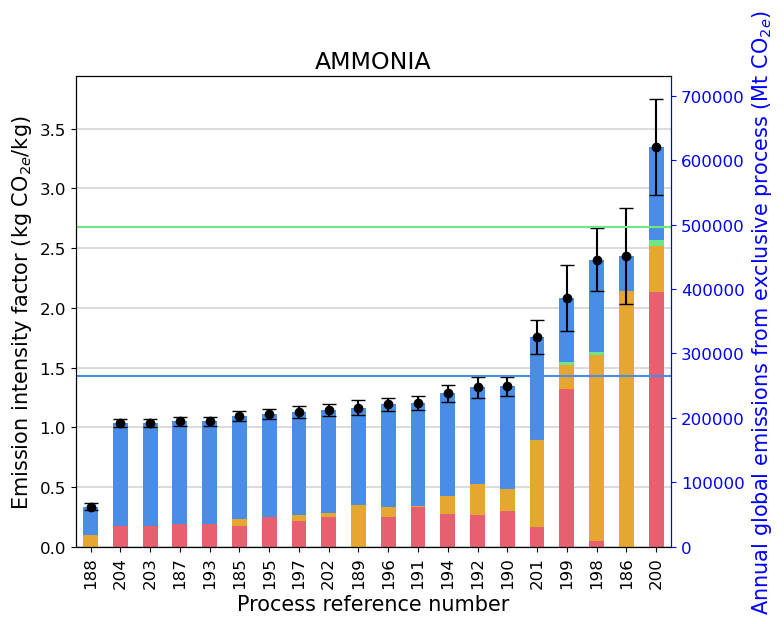

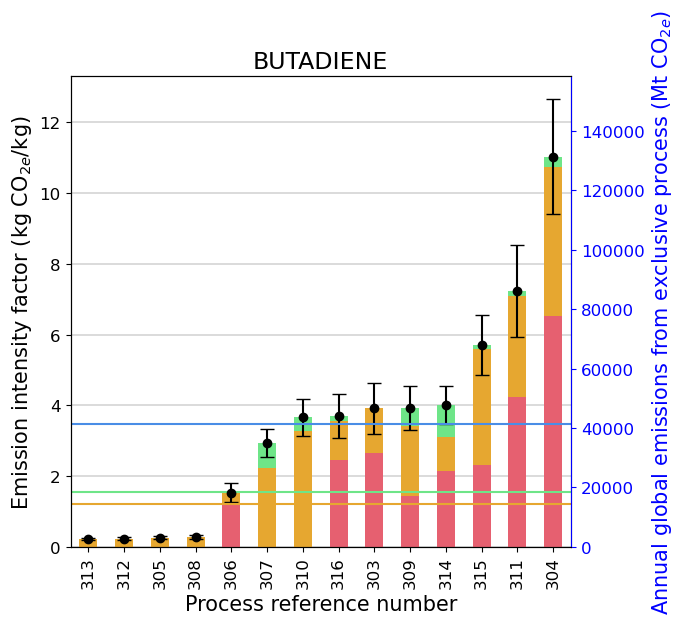

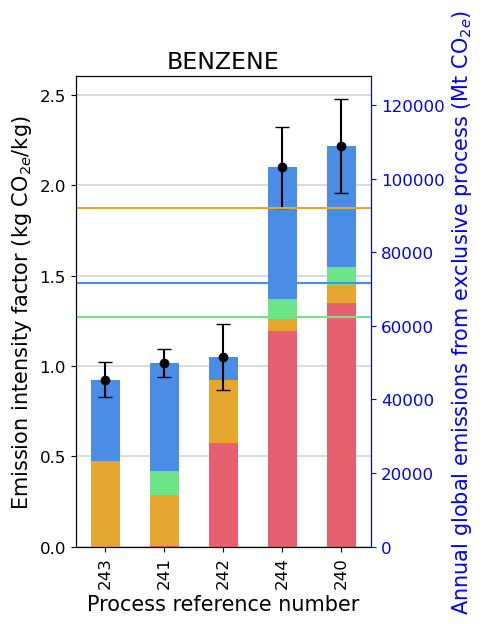

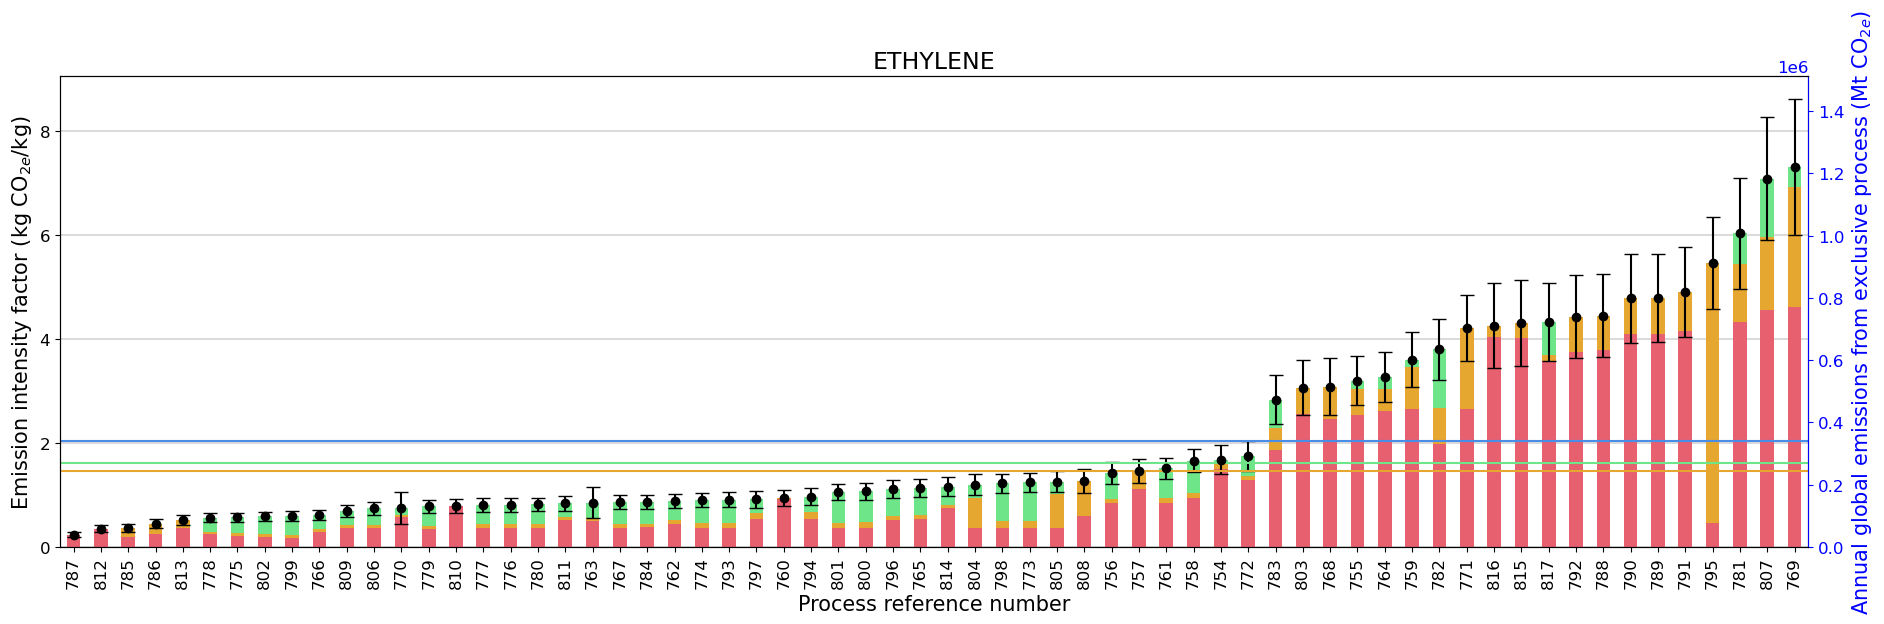

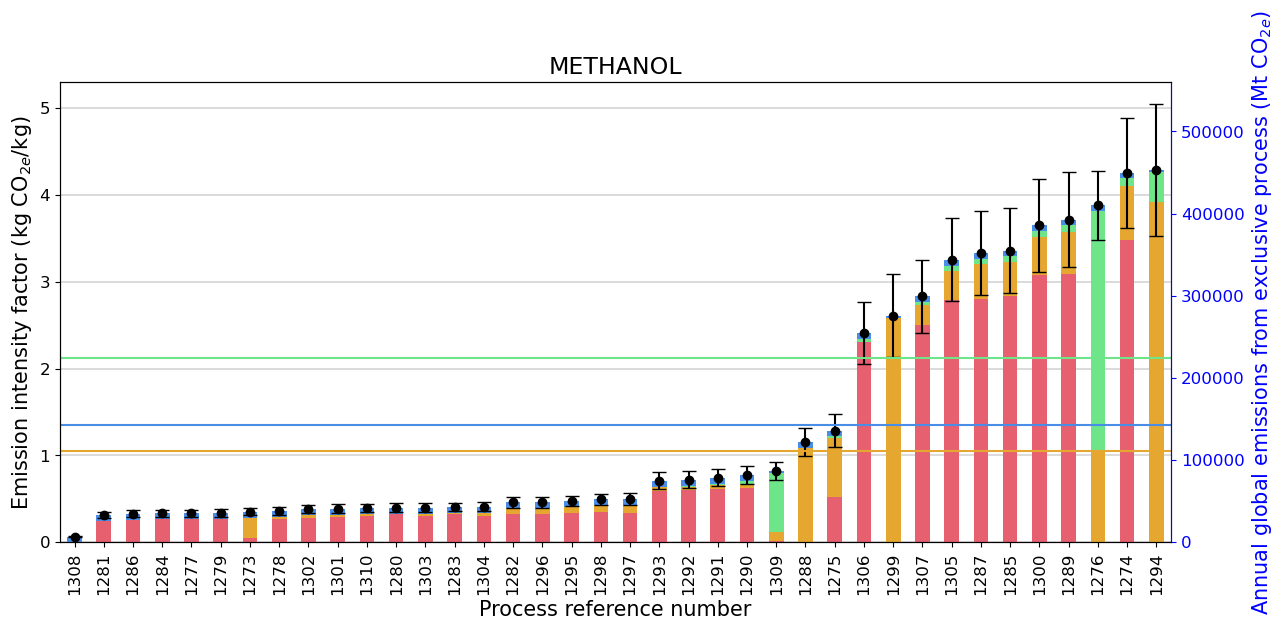

In [108]:
gas = 'CO2e_100a'

primary_chems = ['AMMONIA', 'BUTADIENE', 'BENZENE', 'ETHYLENE', 'METHANOL']#, 'PROPYLENE', 'TOLUENE', 'MIXED\nXYLENES', 'PARA-XYLENE']
plastics = ['ABS', 'HDPE', 'LDPE', 'LLDPE', 'PET', 'POLYESTER\nPOLYMER', 'POLYPROPYLENE', 'POLYSTYRENE', 'PVC']#'EXPANDABLE PS',

for plot_product in primary_chems:
    #plot_product = 'PROPYLENE'
    # exclude = 'ETHYLENE FROM ATMOSPHERIC GAS OIL BY MILLISECOND(TM) CRACKING/DEMETHANIZATION'

    prod = grouped_emissions[grouped_emissions['Product'] == plot_product].sort_values([total_col+'factor'], ascending=True)
    alloc = 'mass'
    total_col = 'ihs_cradle-to-out-gate '+gas+', '+alloc+' allocation '

    #eth_types = pd.read_csv(input_path+'extra_inputs/ethylene_groups.csv', index_col=0)
    # prod_types = prod.merge(eth_types, on='ihs_match').sort_values(['Type', total_col+'factor'], ascending=True)
    #
    # prod_types = prod_types[prod_types['ihs_match']!=exclude]

    total = prod[[total_col+'factor', total_col+'sigma']]
    properties = stages_used#

    breakdown = prod[['ihs_match']+[prop+' '+gas+', '+alloc+' allocation factor' for prop in properties]]#.set_index(['Type'])
    breakdown.rename(columns=dict(zip([prop+' '+gas+', '+alloc+' allocation factor' for prop in properties], properties)), inplace=True)

    # breakdown['Feedstock'] = np.sum(breakdown[['Feedstock', 'Primary chemicals', 'Organic chemicals', 'Other intermediates']], axis=1)
    # properties = ['Feedstock', 'Indirect Utilities', 'Direct Utilities', 'Direct Process']

    breakdown['Feedstock'] = np.sum(breakdown[['Feedstock', 'Primary chemicals', 'Organic chemicals', 'Other intermediates']], axis=1)
    properties = ['Feedstock', 'Indirect Utilities', 'Direct Utilities', 'Direct Process']#, 'Primary chemicals', 'Organic chemicals', 'Other intermediates']

    breakdown = breakdown[['ihs_match']+properties]

    breakdown.rename(columns={'Indirect Utilities':'Indirect Energy Use', 'Direct Utilities': 'Direct Energy Use'}, inplace=True)
    breakdown.dropna(subset=['ihs_match'], inplace=True)

    colors = ['#E66070', '#E6A730','#6EE588','#498DE6','#A055E6']+['pink']

    product_production = total_prod[total_prod['PRODUCT']==plot_product.replace('\n',' ')]['2020'].values
    fontsize = 15
    plt.rcParams['font.size'] = 12
    #sns.set(font_scale=1.5)

    fig, ax = plt.subplots(figsize=[int(3+np.ceil(len(prod)/4)), 6],facecolor='white')

    breakdown.plot.bar(stacked=True, ax=ax, alpha=1,color=colors)

    ax.grid(which='major', axis='y', linestyle='-', color='k', linewidth=0.2, alpha=1)
    ax.set_axisbelow(True)

    ax.errorbar(range(len(total)), total[total.columns[0]], yerr=(total.min(axis=1), total[total.columns[1]]), fmt='o', color='black', ecolor='k', capsize=5, label='Cradle-to-gate EF')
    if prod['ei_CO2e_100a_conv_factor'].dropna().unique() != np.NAN:
        ax.axhline(prod['ei_CO2e_100a_conv_factor'].dropna().unique(), label='LCA database 1', color=colors[1], alpha=1)
    if prod['cm_CO2e_100a_conv_factor'].dropna().unique() != np.NAN:
        ax.axhline(prod['cm_CO2e_100a_conv_factor'].dropna().unique(), label='LCA database 2', color=colors[2], alpha=1)
    ax.axhline(total[total.columns[0]].mean(), label='Mean mass allocation', color=colors[3], alpha=1)

    ax.set_ylabel('Emission intensity factor (kg CO$_{2e}$/kg)', fontsize=fontsize)
    ax.set_xlabel('Process reference number', fontsize=fontsize)
    ax.get_legend().remove()
    #
    ax2 = ax.twinx()
    ax2.set_ylabel('Annual global emissions from exclusive process (Mt CO$_{2e}$)', fontsize=fontsize, color='blue')
    ax2.tick_params(axis='y', labelcolor='blue', color='blue')
    ax2.spines['right'].set_color('blue')
    #
    # Set the limits of the secondary y-axis to be a multiple of the primary y-axis
    y1_min, y1_max = ax.get_ylim()
    y2_min, y2_max = y1_min * product_production, y1_max * product_production
    ax2.set_ylim(y2_min, y2_max)
    ax.set_title(plot_product, fontsize=fontsize+2)

    #ax.legend(fontsize=fontsize-1, framealpha=1, fancybox=True, bbox_to_anchor=[0,-0.1],ncol=4)

    fig.tight_layout()

    fig.savefig('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs\conversionFactors_SI/plastics/'+plot_product.replace('\n','_')+'.png', bbox_inches='tight', dpi=200)

In [103]:
fig.savefig('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs\conversionFactors_SI/legend.png', bbox_inches='tight', dpi=300)

C:\Users\lukec\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\lukec\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
C:\Users\lukec\AppData\Local\Temp/ipykernel_6032/1338101325.py:18: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if prod['cm_CO2e_100a_conv_factor'].dropna().unique() != np.NAN:


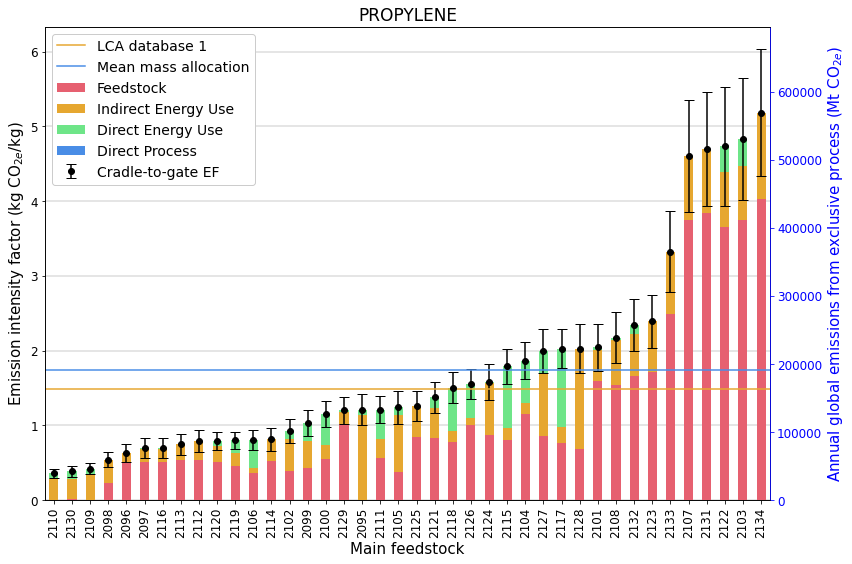

In [73]:
colors = ['#E66070', '#E6A730','#6EE588','#498DE6','#A055E6']+['pink']

product_production = production[production['PRODUCT']==plot_product]['2020'].values
fontsize = 15
plt.rcParams['font.size'] = 12
#sns.set(font_scale=1.5)

fig, ax = plt.subplots(figsize=[12,8], facecolor='white')

breakdown.plot.bar(stacked=True, ax=ax, alpha=1,color=colors)

ax.grid(which='major', axis='y', linestyle='-', color='k', linewidth=0.2, alpha=1)
ax.set_axisbelow(True)

ax.errorbar(range(len(total)), total[total.columns[0]], yerr=(total.min(axis=1), total[total.columns[1]]), fmt='o', color='black', ecolor='k', capsize=5, label='Cradle-to-gate EF')
if prod['ei_CO2e_100a_conv_factor'].dropna().unique() != np.NAN:
    ax.axhline(prod['ei_CO2e_100a_conv_factor'].dropna().unique(), label='LCA database 1', color=colors[1], alpha=1)
if prod['cm_CO2e_100a_conv_factor'].dropna().unique() != np.NAN:
    ax.axhline(prod['cm_CO2e_100a_conv_factor'].dropna().unique(), label='LCA database 2', color=colors[2], alpha=1)
ax.axhline(total[total.columns[0]].mean(), label='Mean mass allocation', color=colors[3], alpha=1)

ax.set_ylabel('Emission intensity factor (kg CO$_{2e}$/kg)', fontsize=fontsize)
ax.set_xlabel('Main feedstock', fontsize=fontsize)
ax.get_legend().remove()
#
ax2 = ax.twinx()
ax2.set_ylabel('Annual global emissions from exclusive process (Mt CO$_{2e}$)', fontsize=fontsize, color='blue')
ax2.tick_params(axis='y', labelcolor='blue', color='blue')
ax2.spines['right'].set_color('blue')
#
# Set the limits of the secondary y-axis to be a multiple of the primary y-axis
y1_min, y1_max = ax.get_ylim()
y2_min, y2_max = y1_min * product_production, y1_max * product_production
ax2.set_ylim(y2_min, y2_max)
ax.set_title(plot_product, fontsize=fontsize+2)

ax.legend(fontsize=fontsize-1, framealpha=1, fancybox=True, loc='upper left')

fig.tight_layout()

In [61]:
y1_min

0.0

## Box plot with production

In [ ]:
# # Import packages
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
#
# ## Inputs
# input_path = '../data/'
# output_path = '../analysis_outputs/'
# combined_factors = pd.read_csv(input_path+'combined/processConversionFactors_w_elec_allgases_allalloc.csv')
# reduced = combined_factors.copy()#[combined_factors.columns[['sigma' not in i for i in combined_factors.columns]]]
#
# # Product grouping
# product_grouping = pd.read_csv(input_path+'extra_inputs/product_groups.csv', index_col=0)
# product_grouping = product_grouping.dropna(subset=['Product group']).reset_index(drop=True)
# grouped_emissions = pd.merge(reduced, product_grouping, left_on='Product', right_on='PRODUCT', how='left')
#
# # Conversion factor plot
#
# ## Inputs
# gas = 'CO2e_100a'
# ihs_property = 'ihs_cradle-to-out-gate '
# allocations = ['mass', 'energy', 'economic']
# take_chemicals = ['ACETIC ACID', 'ACRYLONITRILE', 'AMMONIA', 'POLYPROPYLENE', 'PROPYLENE OXIDE', 'ETHYLENE', 'BUTADIENE', 'BENZENE', 'TOLUENE', 'METHYL METHACRYLATE', 'NYLON 6 CHIPS', 'NYLON 66 RESIN', 'P-XYLENE', 'POLYETHYLENE TEREPHTHALATE', 'POLYETHYLENE, llD', 'POLYETHYLENE, LD', 'UREA']#False
# sample_size = 100
# plt.rcParams.update({'font.size': 12})
#
# ## Get appropriate data
# pe = grouped_emissions.copy()
# pe = pe[['Product','ihs_match']+list(pe.columns[[gas in col for col in pe.columns]])]
#
# if take_chemicals:
#     pe = pe[[i in take_chemicals for i in pe['Product']]]
#     fig, axs = plt.subplots(1,1, figsize=[9,8], facecolor='white')
# else: fig, axs = plt.subplots(1,1, figsize=[10,50], facecolor='white')
#
# ## Loop over allocation types for averages and scatter
# ihs_vals = pd.DataFrame()
# ## Plot IHS values
# for i, (alloc, color) in enumerate(zip(allocations, ['C1', 'C3', 'C4'])):
#
#     column = ihs_property+gas+', '+alloc+' allocation factor'
#     alloc_df = pe[['Product', 'ihs_match', column]].rename(columns={column:'conv_factor'})
#     alloc_df['Allocation'] = alloc
#     ihs_vals = pd.concat((ihs_vals, alloc_df))
#     globals()[alloc+'avg'] = pe.groupby('Product').mean()[column]
#
#     alloc_data = ihs_vals[ihs_vals['Allocation'] == alloc]
#     height_dict = dict(zip(alloc_data['Product'].unique(), range(len(alloc_data['Product'].unique()))))
#
#     axs.scatter(alloc_data['conv_factor'], alloc_data['Product'].replace(height_dict)-0.15+(i*0.15), color=color, s=2, label=alloc.title() +' allocations')
#     axs.scatter(globals()[alloc+'avg'], np.arange(0, len(alloc_data['Product'].unique()))-0.15+(i*0.15), color=color, s=50, marker=(5, 1), label=alloc.title() +' allocation mean')
#
# ## Get single values
# ihs_mins = ihs_vals.groupby('Product').min()['conv_factor']
# ihs_maxs = ihs_vals.groupby('Product').max()['conv_factor']
# cm_vals = pe.groupby('Product').max()['cm_'+gas+'_conv_factor']
# ei_vals = pe.groupby('Product').max()['ei_'+gas+'_conv_factor']
# if gas == 'CO2e_100a':
#     ifa_vals = pe.groupby('Product').max()['ifa_'+gas+'_CtOG factor']
#
# ## Plot CM & EI values
# axs.scatter(cm_vals, np.arange(0, len(cm_vals)), color='c', label='Carbon Minds values')
# axs.scatter(ei_vals, np.arange(0, len(cm_vals)), color='g', label='EcoInvent values')
# if gas == 'CO2e_100a':
#     axs.scatter(ifa_vals, np.arange(0, len(cm_vals)), color='b', label='IFA values')
#
# merged_limits = ihs_mins.reset_index().merge(ei_vals.reset_index()).merge(cm_vals.reset_index()).merge(ifa_vals.reset_index()).merge(ihs_maxs.reset_index().rename(columns={'conv_factor':'maxs'}))
#
# axs.barh(ihs_mins.index.values, merged_limits.max(axis=1)-merged_limits.min(axis=1), left=merged_limits.min(axis=1), color='C1', alpha=0.15, label='Range of EFs')
#
#
# fontsize = 14
# axs.set_title('Petrochemical production emission intensity factors', fontsize=fontsize+2)
# axs.invert_yaxis()
# axs.set_xscale('symlog')
# axs.set_xlim([-0.2, 30])
# axs.set_xlabel('Emission intensity factor (kg CO$_{2eq}$ / kg product)', fontsize=fontsize)
# axs.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
# axs.legend(bbox_to_anchor=(1.01, 0.75), fontsize=fontsize)